In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from itertools import cycle, islice
sb.set()
#Machine learning libaries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve

!pip install shap
import shap

In [2]:
#Importing data from csv
netflix_data_raw=pd.read_csv('netflix_titles.csv', on_bad_lines='warn')
netflix_data_raw.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [3]:
#Keeping only what we are using
data_needed=['country','type','rating','duration','release_year','description']
netflix_data=netflix_data_raw[data_needed]
netflix_data

,country,type,rating,duration,release_year,description
0,United States,Movie,PG-13,90 min,2020,"As her father nears the end of his life, filmm..."
1,South Africa,TV Show,TV-MA,2 Seasons,2021,"After crossing paths at a party, a Cape Town t..."
2,NaN,TV Show,TV-MA,1 Season,2021,To protect his family from a powerful drug lor...
3,NaN,TV Show,TV-MA,1 Season,2021,"Feuds, flirtations and toilet talk go down amo..."
4,India,TV Show,TV-MA,2 Seasons,2021,In a city of coaching centers known to train I...
...,...,...,...,...,...,...
8802,United States,Movie,R,158 min,2007,"A political cartoonist, a crime reporter and a..."
8803,NaN,TV Show,TV-Y7,2 Seasons,2018,"While living alone in a spooky town, a young g..."
8804,United States,Movie,R,88 min,2009,Looking to survive in a world taken over by zo...
8805,United States,Movie,PG,88 min,2006,"Dragged from civilian life, a former superhero..."


# Data Preparation
Written by Bryan/Yee Jey/Yan Jun

<Axes: ylabel='count'>

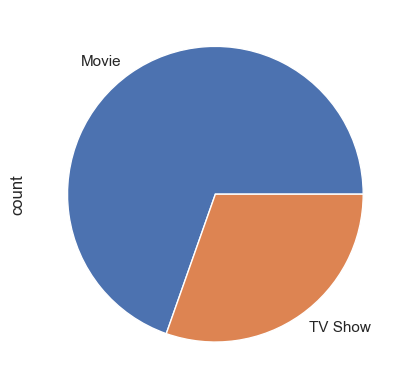

In [4]:
types = netflix_data["type"].value_counts()
typesnames = netflix_data["type"].value_counts().index
types
netflix_data["type"].value_counts().plot(kind = "pie")

In [5]:
def preprocess_netflix_data(netflix_data, category_column, content_column='type'):
    # Split the database into TV shows and movies
    netflix_content_movie = netflix_data[netflix_data[content_column] == 'Movie']
    netflix_content_show = netflix_data[netflix_data[content_column] == 'TV Show']

    # Drop the 'type' column
    netflix_content_movie = netflix_content_movie.drop(columns=[content_column])
    netflix_content_show = netflix_content_show.drop(columns=[content_column])

    # Drop rows with missing values in the any category column
    netflix_content_movie.dropna(axis=0, inplace=True)
    netflix_content_show.dropna(axis=0, inplace=True)

    # Expand multi-country data
    netflix_content_movie = expand_multi_country_data(netflix_content_movie, category_column)
    netflix_content_show = expand_multi_country_data(netflix_content_show, category_column)

    for col in netflix_content_movie.select_dtypes(include=['object']).columns:
        netflix_content_movie[col] = netflix_content_movie[col].apply(lambda x: ''.join(x.split()))

    for col in netflix_content_show.select_dtypes(include=['object']).columns:
        netflix_content_show[col] = netflix_content_show[col].apply(lambda x: ''.join(x.split()))


    return netflix_content_movie, netflix_content_show

def expand_multi_country_data(df, country_column='country'):
    # Identify rows with multiple countries of origin
    multi_country_rows = df[df[country_column].str.contains(',')]

    # Split rows with multiple countries into separate rows
    split_countries = multi_country_rows[country_column].str.split(',')
    split_countries_df = pd.DataFrame(split_countries.tolist(), index=multi_country_rows.index).stack()
    split_countries_df = split_countries_df.reset_index(level=1, drop=True).rename(country_column)

    # Duplicate other columns as needed to ensure each country has its corresponding data
    duplicated_columns = multi_country_rows.drop(country_column, axis=1).loc[split_countries_df.index]

    # Combine the modified rows with the original DataFrame
    expanded_df = pd.concat([df.drop(multi_country_rows.index), duplicated_columns.join(split_countries_df)], axis=0)
    expanded_df.reset_index(drop=True, inplace=True)

    return expanded_df

In [6]:
netflix_movie_data, netflix_tv_show_data = preprocess_netflix_data(netflix_data, 'country')
print('Movie Data',netflix_movie_data.head(),'\n')
print('TV Show Data',netflix_tv_show_data.head())

Movie Data         country rating duration  release_year  \
0  UnitedStates  PG-13    90min          2020   
1  UnitedStates  PG-13   104min          2021   
2         India  TV-14   166min          1998   
3  UnitedStates  PG-13   103min          2010   
4  UnitedStates  PG-13    97min          2013   

                                         description  
0  Asherfathernearstheendofhislife,filmmakerKirst...  
1  Awomanadjustingtolifeafteralosscontendswithafe...  
2  Whenthefatherofthemanshelovesinsiststhathistwi...  
3  Mourningthelossoftheirbelovedjuniorhighbasketb...  
4  Afamily’sidyllicsuburbanlifeshatterswhenanalie...   

TV Show Data          country rating  duration  release_year  \
0    SouthAfrica  TV-MA  2Seasons          2021   
1          India  TV-MA  2Seasons          2021   
2  UnitedKingdom  TV-14  9Seasons          2021   
3   UnitedStates  TV-MA  4Seasons          2021   
4         Mexico  TV-MA  2Seasons          2020   

                                         d

In [7]:
#Fix the '' data
netflix_movie_data = netflix_movie_data[netflix_movie_data['country'] != '']
netflix_tv_show_data = netflix_tv_show_data[netflix_tv_show_data['country'] != '']

# Cutting down on the dataset
This is due to the large amount of countries that produce little movie but skews the results. Over here we aim to remove at most 1% of movies, however this removes a good amount of countries making it easier to predict<br>
Written by Bryan

Number of countries representing 5% of the graph from the left: 5
Number of countries representing 5% of the graph from the left: 3


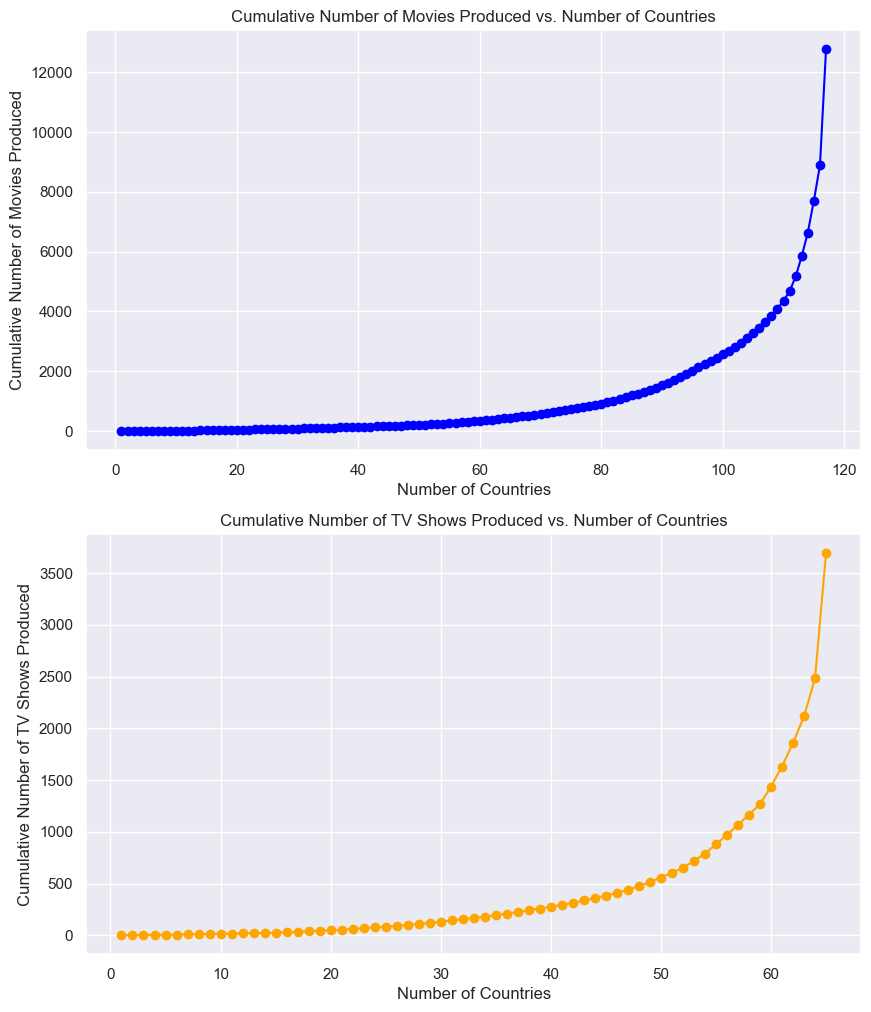

In [8]:
# Count the number of movies produced by each country
country_movie_counts = netflix_movie_data['country'].value_counts()
sorted_countries_movie = country_movie_counts.sort_values()
cumulative_movies = sorted_countries_movie.cumsum()

# Count the number of TV shows produced by each country
country_tv_show_counts = netflix_tv_show_data['country'].value_counts()
sorted_countries_tv_show = country_tv_show_counts.sort_values()
cumulative_tv_shows = sorted_countries_tv_show.cumsum()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Plot the cumulative number of movies produced against the number of countries
ax1.plot(range(1, len(sorted_countries_movie) + 1), cumulative_movies.values, marker='o', color='blue')
ax1.set_xlabel('Number of Countries')
ax1.set_ylabel('Cumulative Number of Movies Produced')
ax1.set_title('Cumulative Number of Movies Produced vs. Number of Countries')
ax1.grid(True)

# Plot the cumulative number of TV shows produced against the number of countries
ax2.plot(range(1, len(sorted_countries_tv_show) + 1), cumulative_tv_shows.values, marker='o', color='orange')
ax2.set_xlabel('Number of Countries')
ax2.set_ylabel('Cumulative Number of TV Shows Produced')
ax2.set_title('Cumulative Number of TV Shows Produced vs. Number of Countries')
ax2.grid(True)

num_countries_movie = int(0.05 * len(sorted_countries_movie))
print(f"Number of countries representing 5% of the graph from the left: {num_countries_movie}")
num_countries_show = int(0.05 * len(sorted_countries_tv_show))
print(f"Number of countries representing 5% of the graph from the left: {num_countries_show}")

In [9]:
#For Movies
movie_country_counts = netflix_movie_data['country'].value_counts()

#This code remove countries based on cut off above
filtered_movie_countries = movie_country_counts[movie_country_counts >= num_countries_movie].index.tolist()
netflix_movie_data = netflix_movie_data[netflix_movie_data['country'].isin(filtered_movie_countries)]

#For TV shows
tv_show_country_counts = netflix_tv_show_data['country'].value_counts()

#This code remove countries based on cut off above
filtered_tv_show_countries = tv_show_country_counts[tv_show_country_counts >= num_countries_show].index.tolist()
netflix_tv_show_data = netflix_tv_show_data[netflix_tv_show_data['country'].isin(filtered_tv_show_countries)]


# Converting our dataset into usable data

In [10]:
print(netflix_movie_data.dtypes)
print(netflix_tv_show_data.dtypes)

country         object
rating          object
duration        object
release_year     int64
description     object
dtype: object
country         object
rating          object
duration        object
release_year     int64
description     object
dtype: object


## Duration
Bryan

In [11]:
#Converting duration into useful data
if netflix_movie_data['duration'].dtype=='int':
    pass
else:
    netflix_movie_data['duration']=netflix_movie_data['duration'].str.extract('(\d+)').astype(int)
netflix_movie_data['country']=netflix_movie_data['country'].astype('category')

if netflix_tv_show_data['duration'].dtype=='int':
    pass
else:
    netflix_tv_show_data['duration']=netflix_tv_show_data['duration'].str.extract('(\d+)').astype(int)
netflix_tv_show_data['country']=netflix_tv_show_data['country'].astype('category')

print(netflix_movie_data.dtypes)
print(netflix_tv_show_data.dtypes)

country         category
rating            object
duration           int32
release_year       int64
description       object
dtype: object
country         category
rating            object
duration           int32
release_year       int64
description       object
dtype: object


## Age Rating
Yee Jey

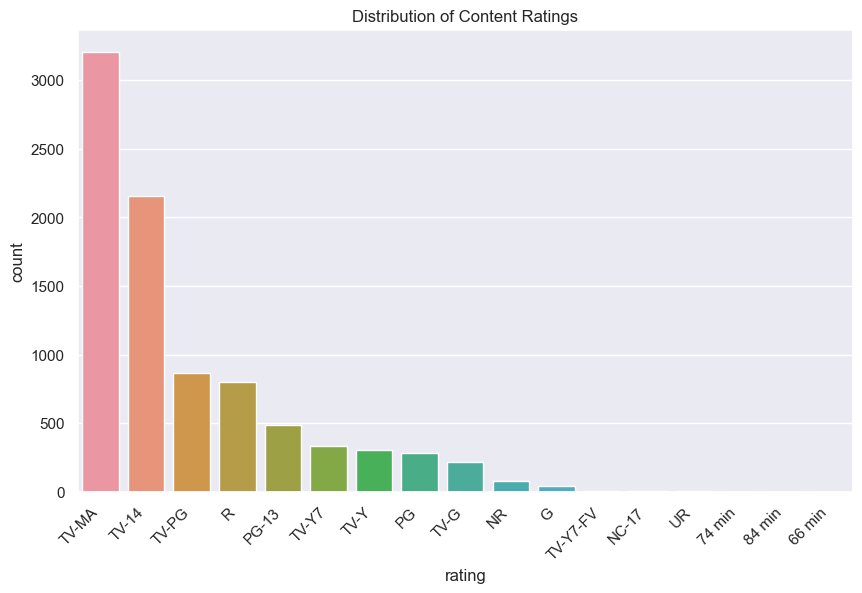

In [12]:
plt.figure(figsize=(10, 6))
sb.countplot(x='rating', data=netflix_data, order=netflix_data['rating'].value_counts().index)
plt.title('Distribution of Content Ratings')
plt.xticks(rotation=45, ha='right')
plt.show()

In [13]:
ratings_based_on_age = {
    'TV-PG': 'Parental Guidance',
    'TV-MA' : 'Mature Audience',
    'TV-Y7-FV': 'Teens',
    'TV-Y7': 'Teens',
    'TV-14': 'Teens',
    'R': 'Mature Audience',
    'TV-Y': 'General Audience',
    'NR': 'Mature Audience',
    'PG-13': 'Teens',
    'TV-G': 'General Audience',
    'PG': 'Teens',
    'G': 'General Audience',
    'UR': 'Mature Audience',
    'NC-17': 'Mature Audience'
}

if 'rating' in netflix_movie_data.columns:
#Adding a new column which tells what kind of audience are eligible to watch
    netflix_movie_data['Target_audience'] = netflix_movie_data['rating'].replace(ratings_based_on_age)
    netflix_movie_data.drop(columns=['rating'], inplace=True)
if 'rating' in netflix_tv_show_data.columns:
#Adding a new column which tells what kind of audience are eligible to watch
    netflix_tv_show_data['Target_audience'] = netflix_tv_show_data['rating'].replace(ratings_based_on_age)
    netflix_tv_show_data.drop(columns=['rating'], inplace=True)



netflix_movie_data['Target_audience']=netflix_movie_data['Target_audience'].astype('category')
netflix_tv_show_data['Target_audience']=netflix_tv_show_data['Target_audience'].astype('category')


print(netflix_movie_data.dtypes)
print(netflix_tv_show_data.dtypes)

country            category
duration              int32
release_year          int64
description          object
Target_audience    category
dtype: object
country            category
duration              int32
release_year          int64
description          object
Target_audience    category
dtype: object


## Description Length
Bryan

In [14]:
#Modifying description length - Bryan
if 'description' in netflix_movie_data.columns:
    description_length = netflix_movie_data['description'].str.len().astype(int)
    netflix_movie_data['description_length'] = description_length
    netflix_movie_data.drop(columns=['description'], inplace=True)
if 'description' in netflix_tv_show_data.columns:
    description_length = netflix_tv_show_data['description'].str.len().astype(int)
    netflix_tv_show_data['description_length'] = description_length
    netflix_tv_show_data.drop(columns=['description'], inplace=True)

print(netflix_movie_data.dtypes)
print(netflix_tv_show_data.dtypes)

country               category
duration                 int32
release_year             int64
Target_audience       category
description_length       int32
dtype: object
country               category
duration                 int32
release_year             int64
Target_audience       category
description_length       int32
dtype: object


# Visualizing Movie data
Written by Bryan/ Yee Jey

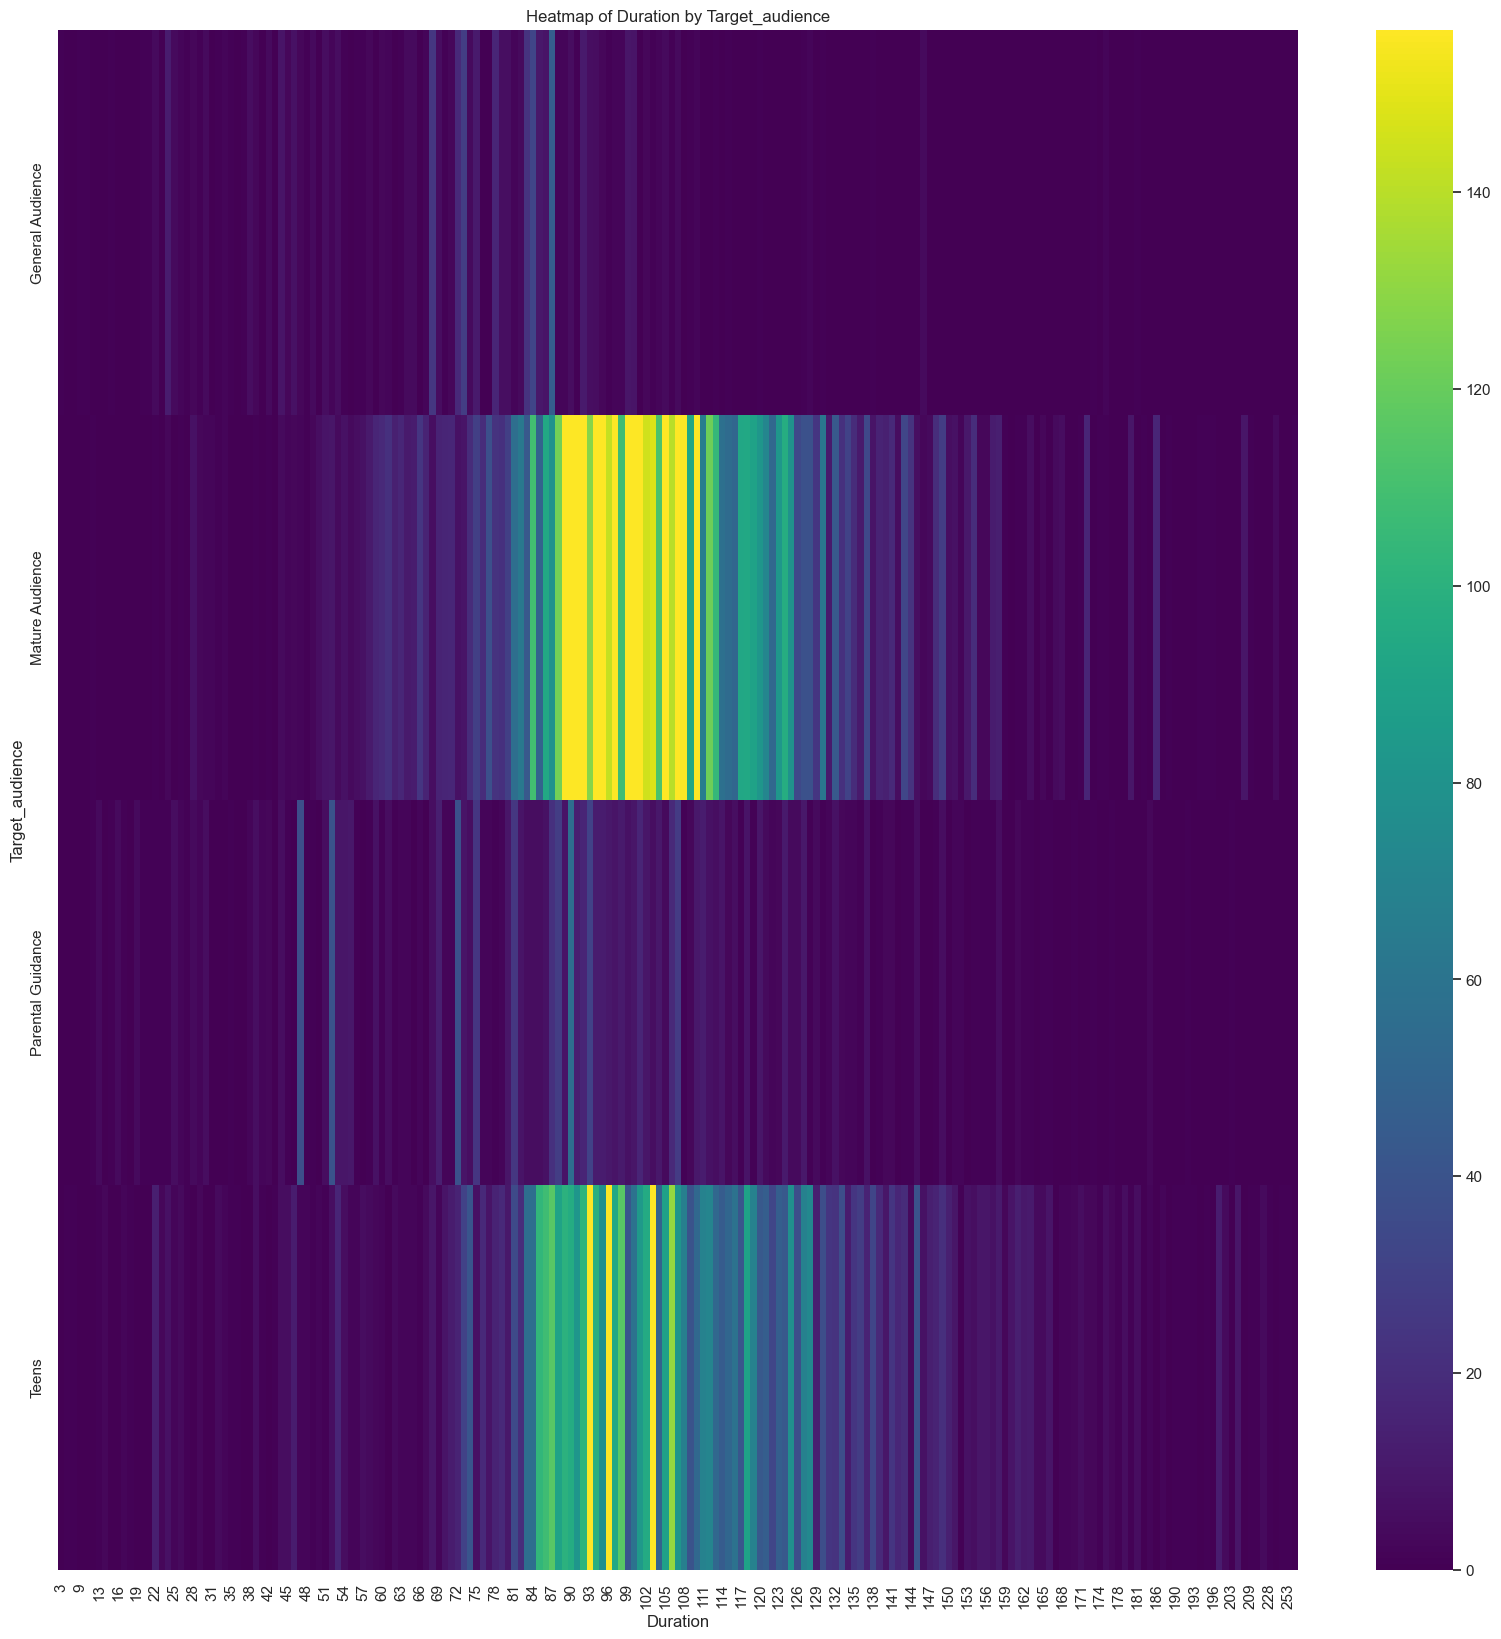

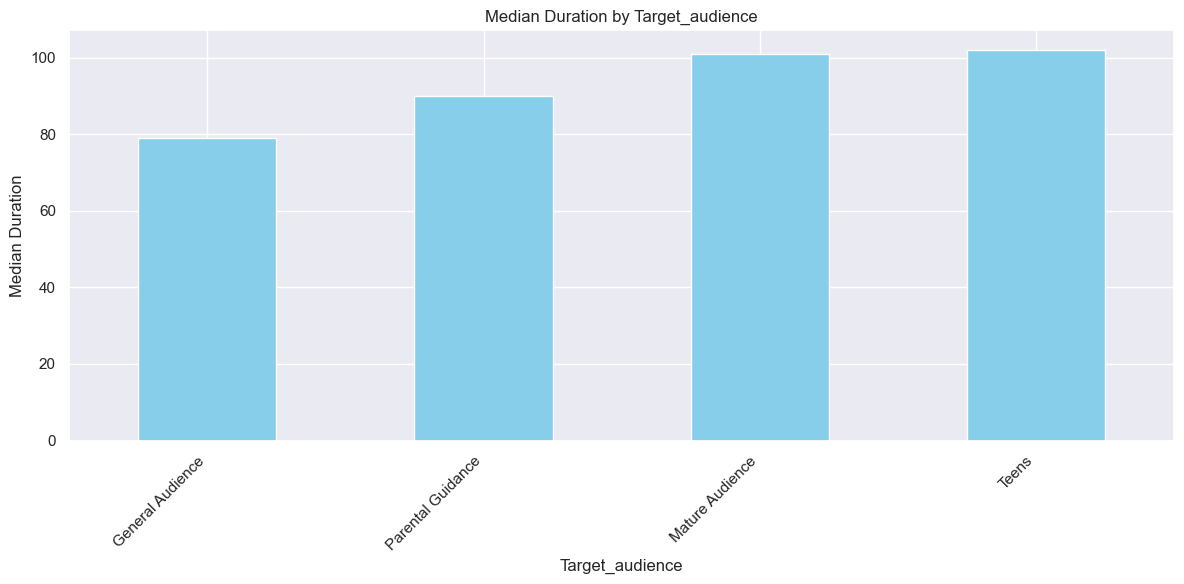

In [15]:
#Duration-Bryan
heatmap_data=netflix_movie_data.pivot_table(index='Target_audience', columns='duration', aggfunc='size')
# Plot the heatmap
plt.figure(figsize=(20, 20))
sb.heatmap(heatmap_data, cmap='viridis', robust=True)
plt.xlabel('Duration')
plt.ylabel('Target_audience')
plt.title('Heatmap of Duration by Target_audience')
plt.show()
# Calculate the average duration for each country
avg_duration = netflix_movie_data.groupby('Target_audience')['duration'].median().sort_values()

# Plotting
plt.figure(figsize=(12, 6))
avg_duration.plot(kind='bar', color='skyblue')
plt.title('Median Duration by Target_audience')
plt.xlabel('Target_audience')
plt.ylabel('Median Duration')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Target_audience
Mature Audience      6523
Teens                4828
Parental Guidance     888
General Audience      453
Name: count, dtype: int64


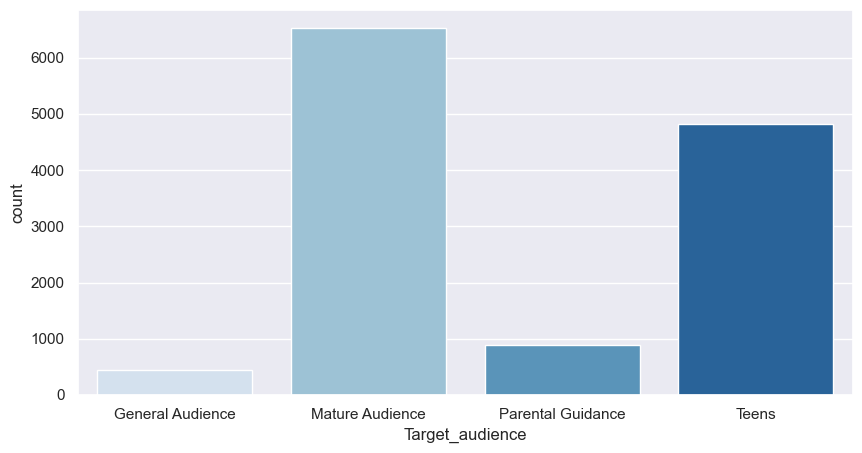

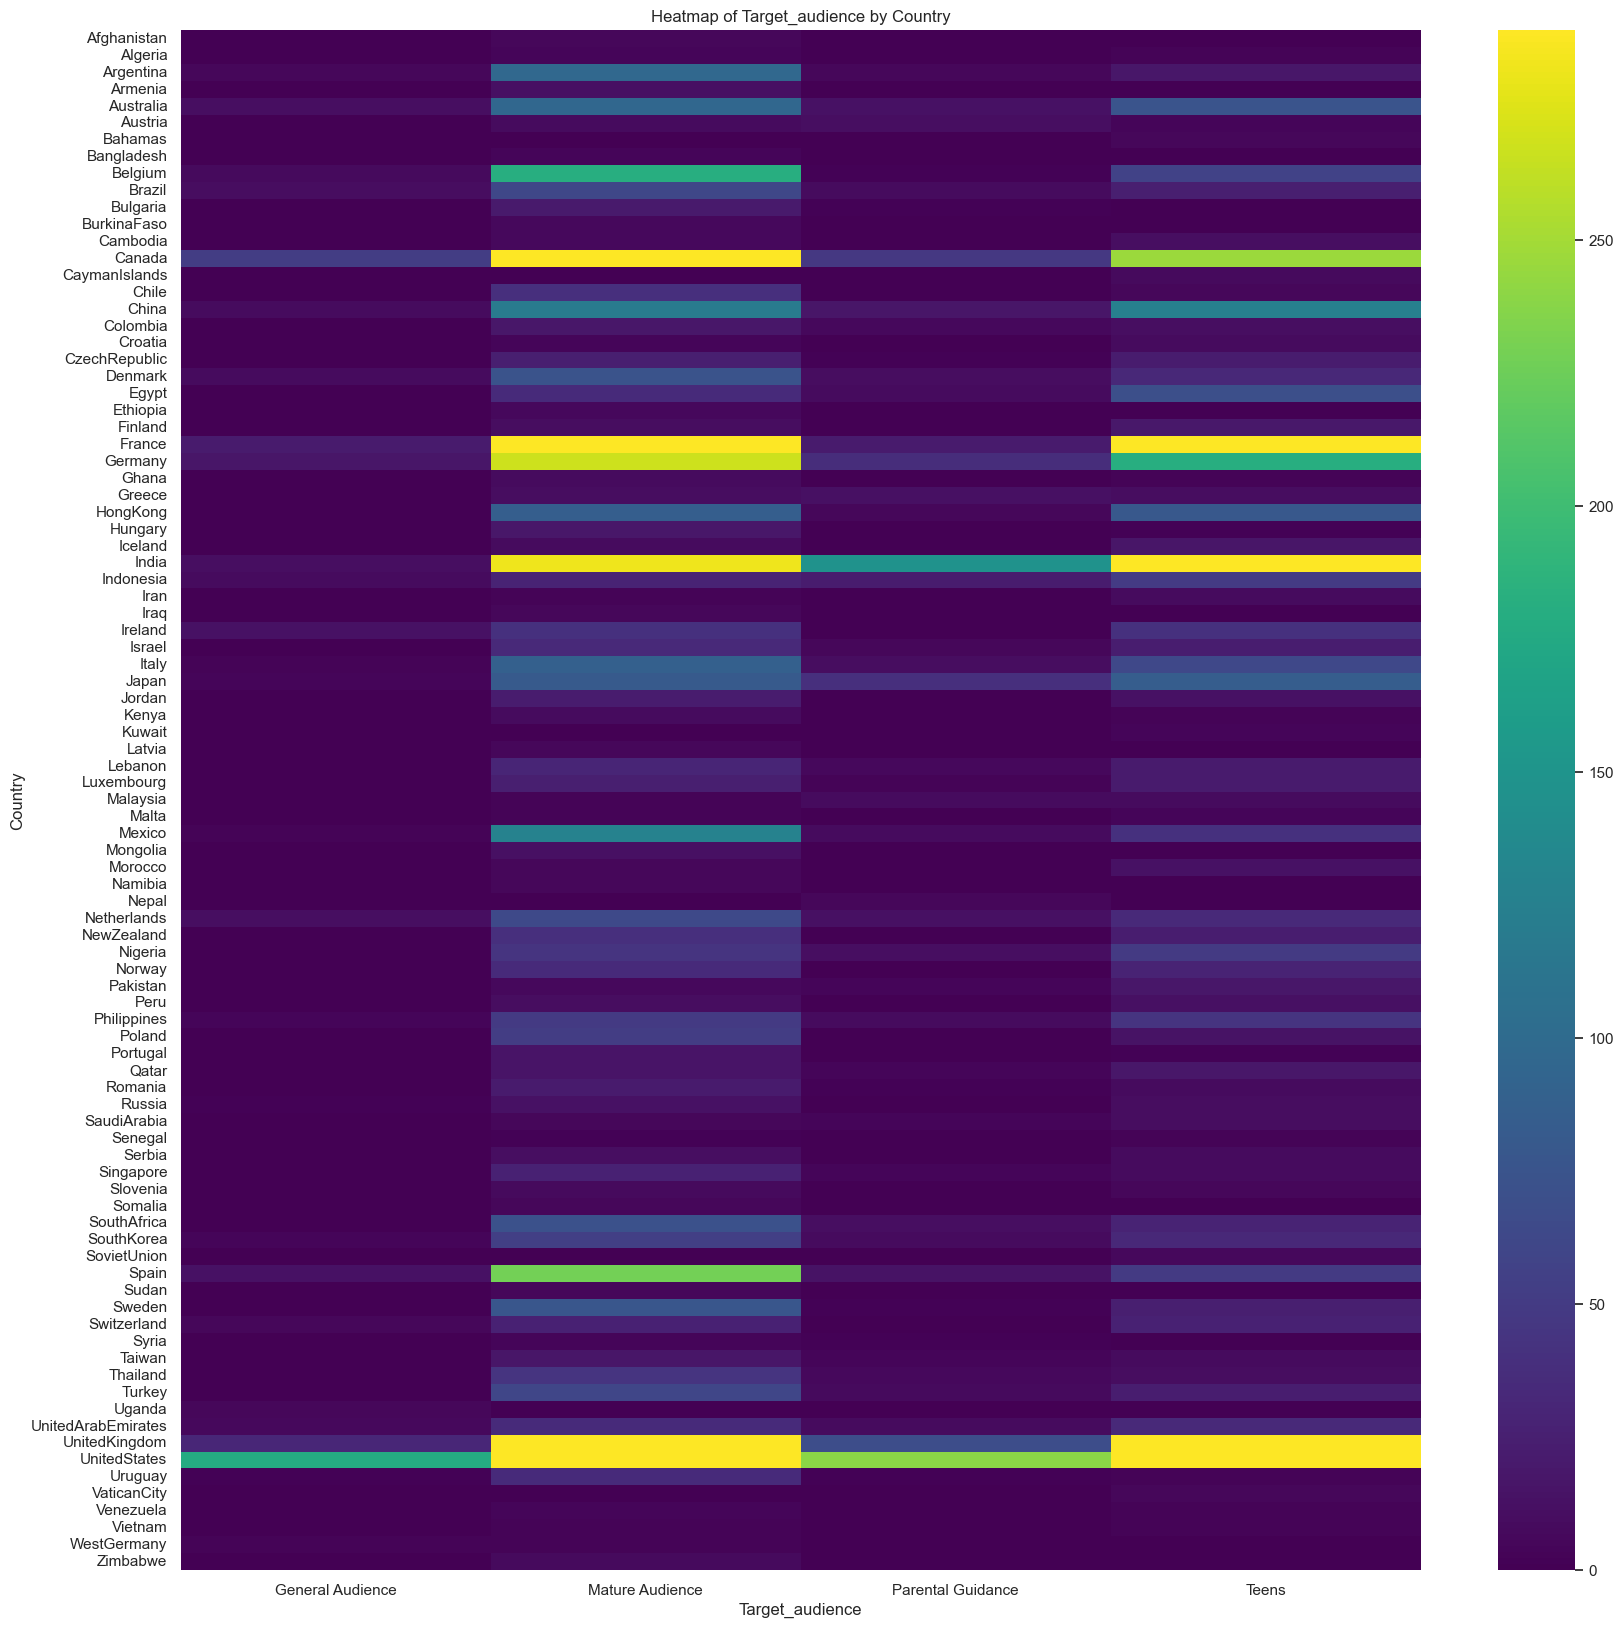

In [16]:
#Visualizing country
print(netflix_movie_data.Target_audience.value_counts())
plt.figure(figsize = (10,5))
sb.countplot(x="Target_audience",data = netflix_movie_data, palette = "Blues")
#Target Audience
heatmap_data=netflix_movie_data.pivot_table(index='country', columns='Target_audience', aggfunc='size')
# Plot the heatmap
plt.figure(figsize=(20, 20))
sb.heatmap(heatmap_data, cmap='viridis', robust=True)
plt.xlabel('Target_audience')
plt.ylabel('Country')
plt.title('Heatmap of Target_audience by Country')
plt.show()


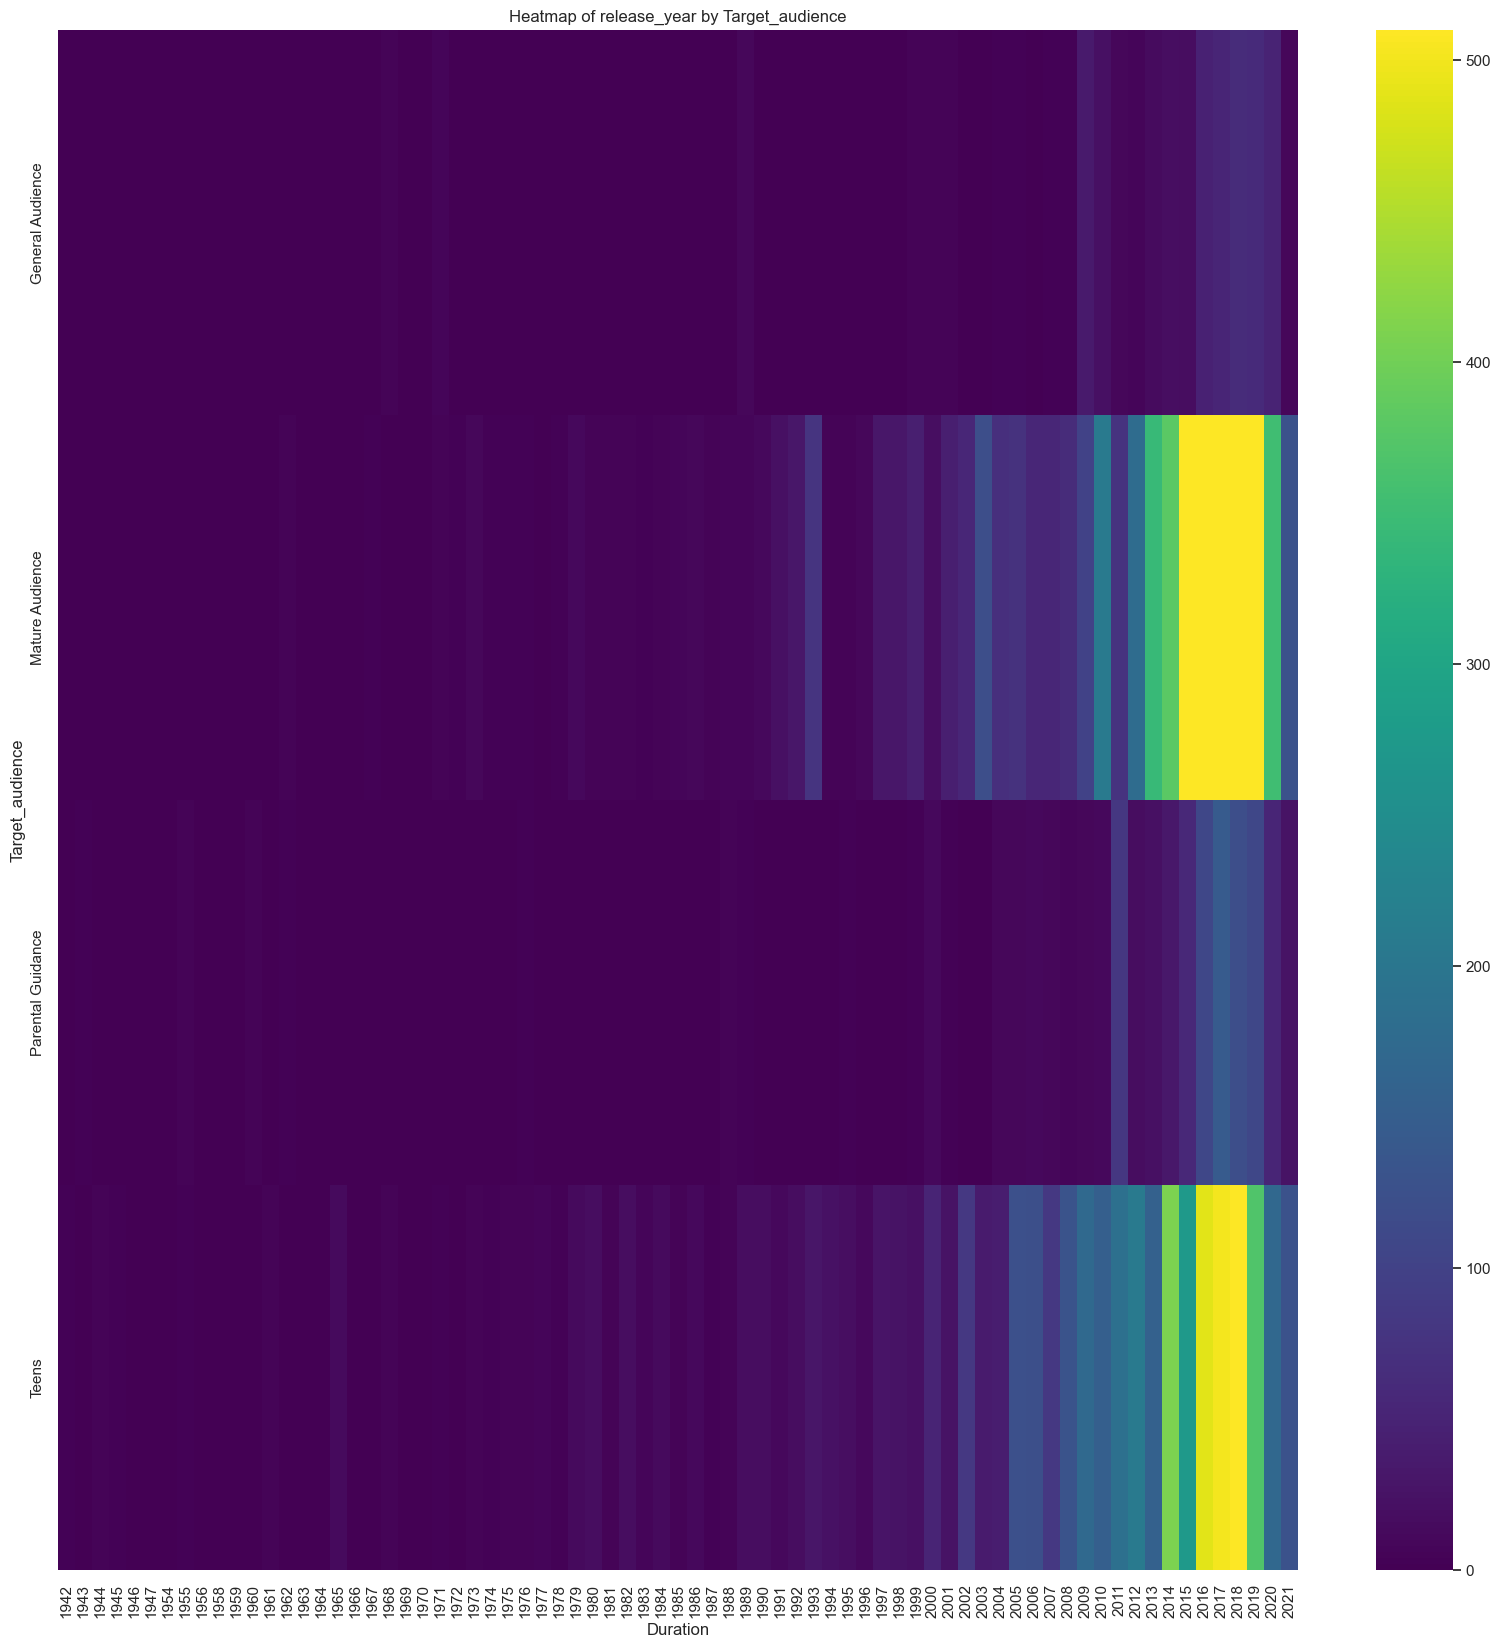

In [17]:
#Visualizing Release Year
heatmap_data=netflix_movie_data.pivot_table(index='Target_audience', columns='release_year', aggfunc='size')
# Plot the heatmap
plt.figure(figsize=(20, 20))
sb.heatmap(heatmap_data, cmap='viridis', robust=True)
plt.xlabel('Duration')
plt.ylabel('Target_audience')
plt.title('Heatmap of release_year by Target_audience')
plt.show()

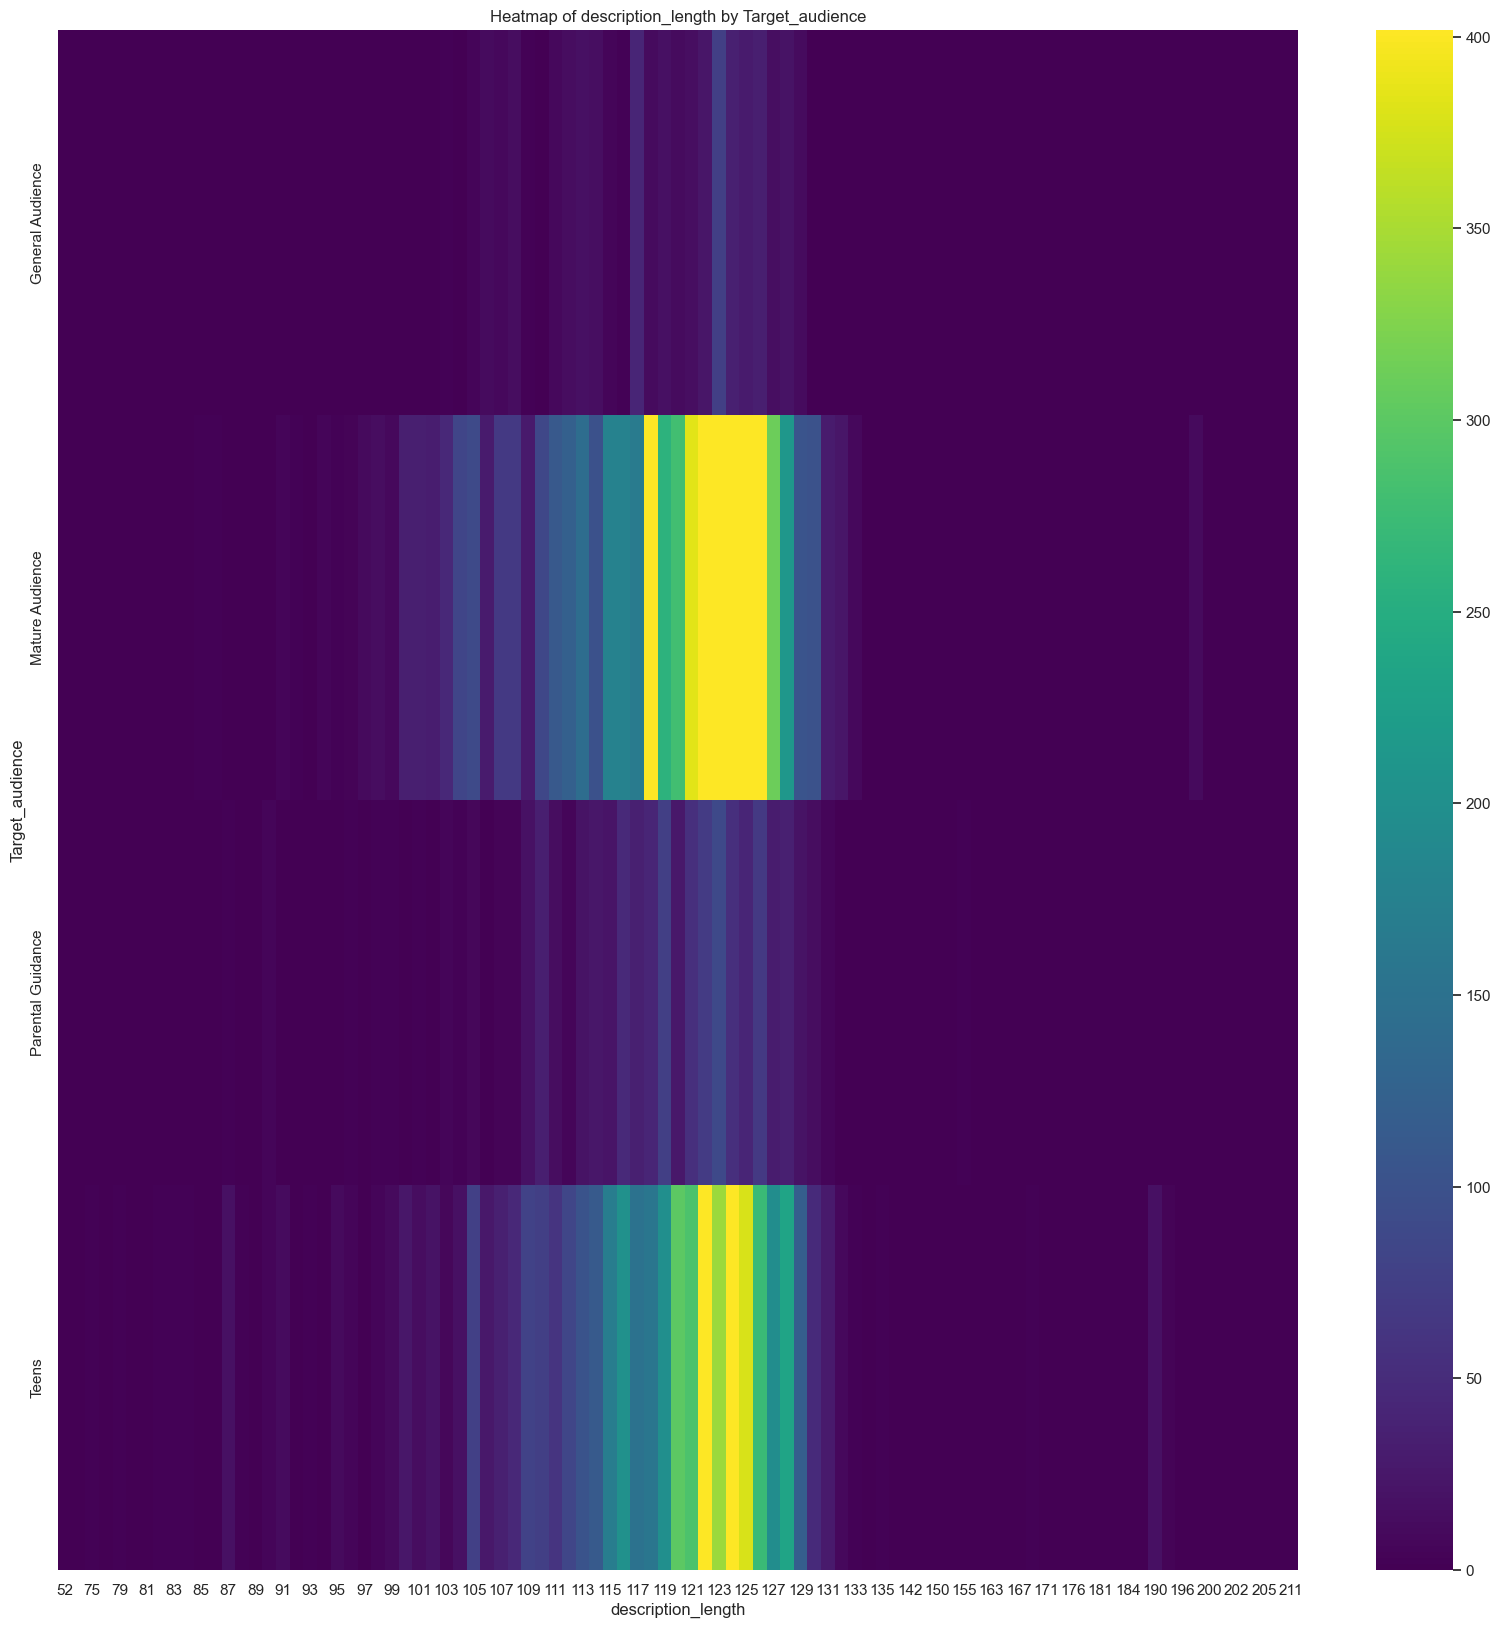

In [18]:
#Visualizing Description Length
heatmap_data=netflix_movie_data.pivot_table(index='Target_audience', columns='description_length', aggfunc='size')
# Plot the heatmap
plt.figure(figsize=(20, 20))
sb.heatmap(heatmap_data, cmap='viridis', robust=True)
plt.xlabel('description_length')
plt.ylabel('Target_audience')
plt.title('Heatmap of description_length by Target_audience')
plt.show()

# Visualizing TV SHOW Data

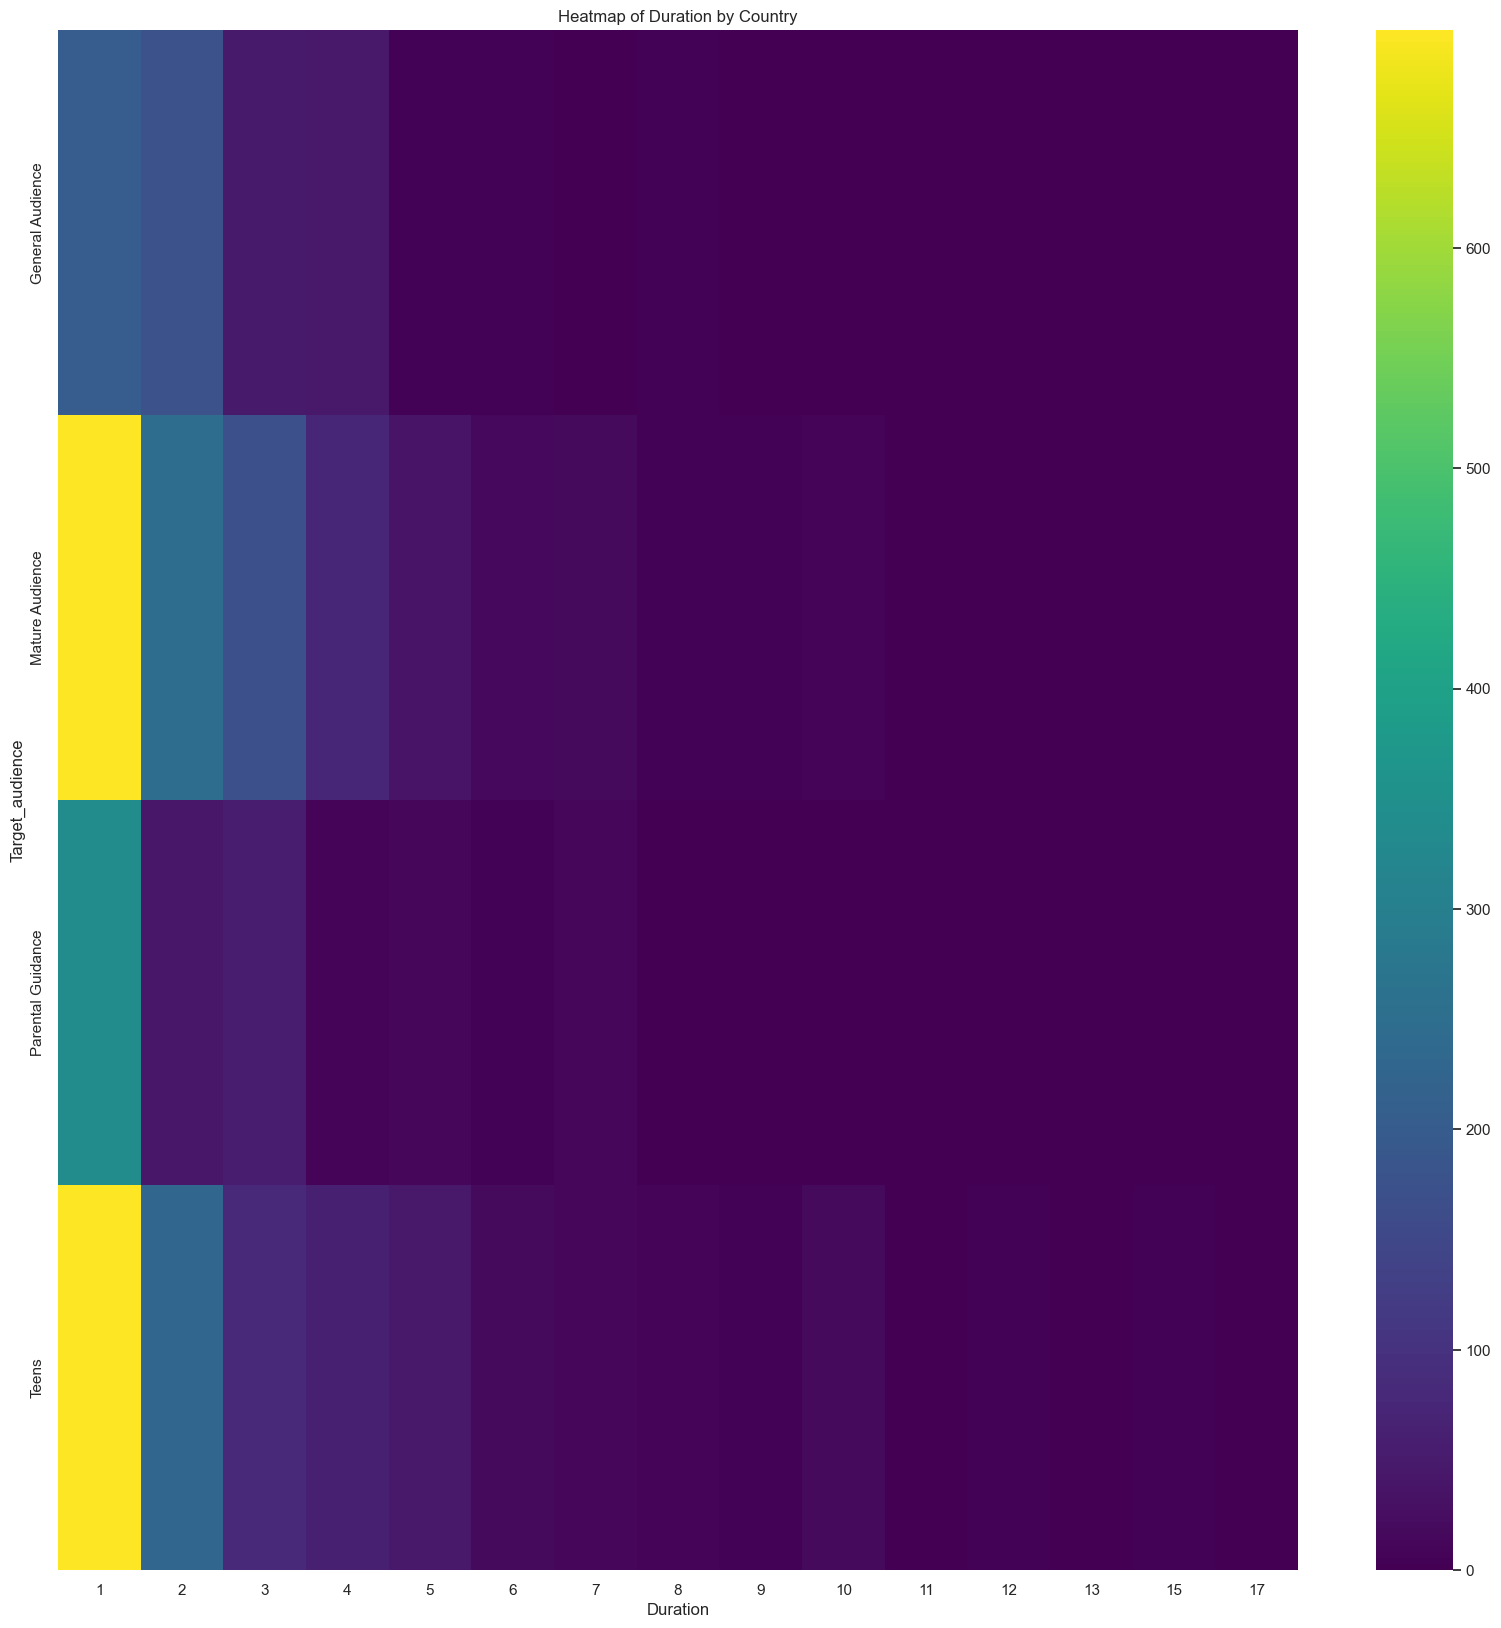

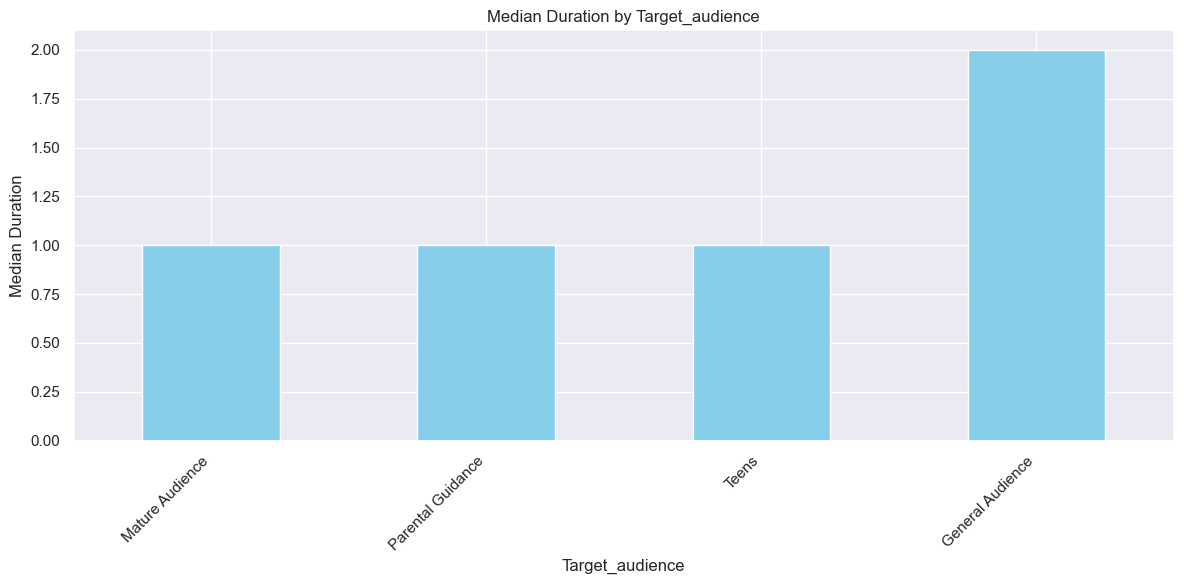

In [19]:
#Duration
heatmap_data=netflix_tv_show_data.pivot_table(index='Target_audience', columns='duration', aggfunc='size')
# Plot the heatmap
plt.figure(figsize=(20, 20))
sb.heatmap(heatmap_data, cmap='viridis', robust=True)
plt.xlabel('Duration')
plt.ylabel('Target_audience')
plt.title('Heatmap of Duration by Country')
plt.show()
# Calculate the average duration for each country
avg_duration = netflix_tv_show_data.groupby('Target_audience')['duration'].median().sort_values()

# Plotting
plt.figure(figsize=(12, 6))
avg_duration.plot(kind='bar', color='skyblue')
plt.title('Median Duration by Target_audience')
plt.xlabel('Target_audience')
plt.ylabel('Median Duration')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Target_audience
Mature Audience      1447
Teens                1262
General Audience      486
Parental Guidance     475
Name: count, dtype: int64


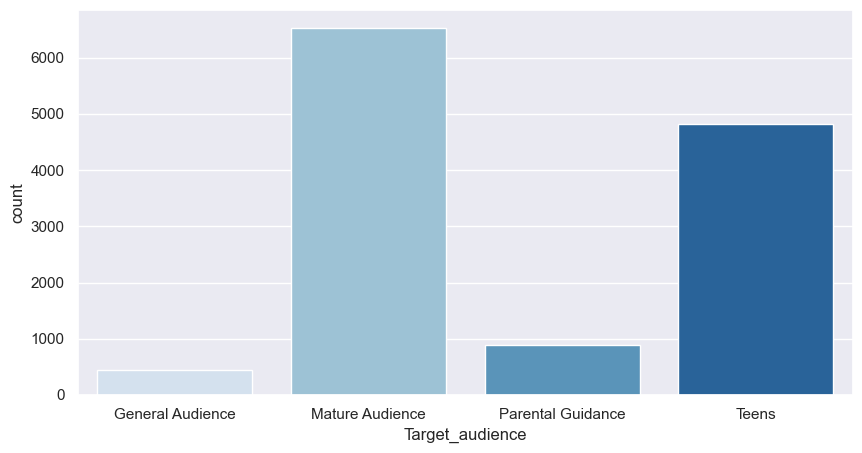

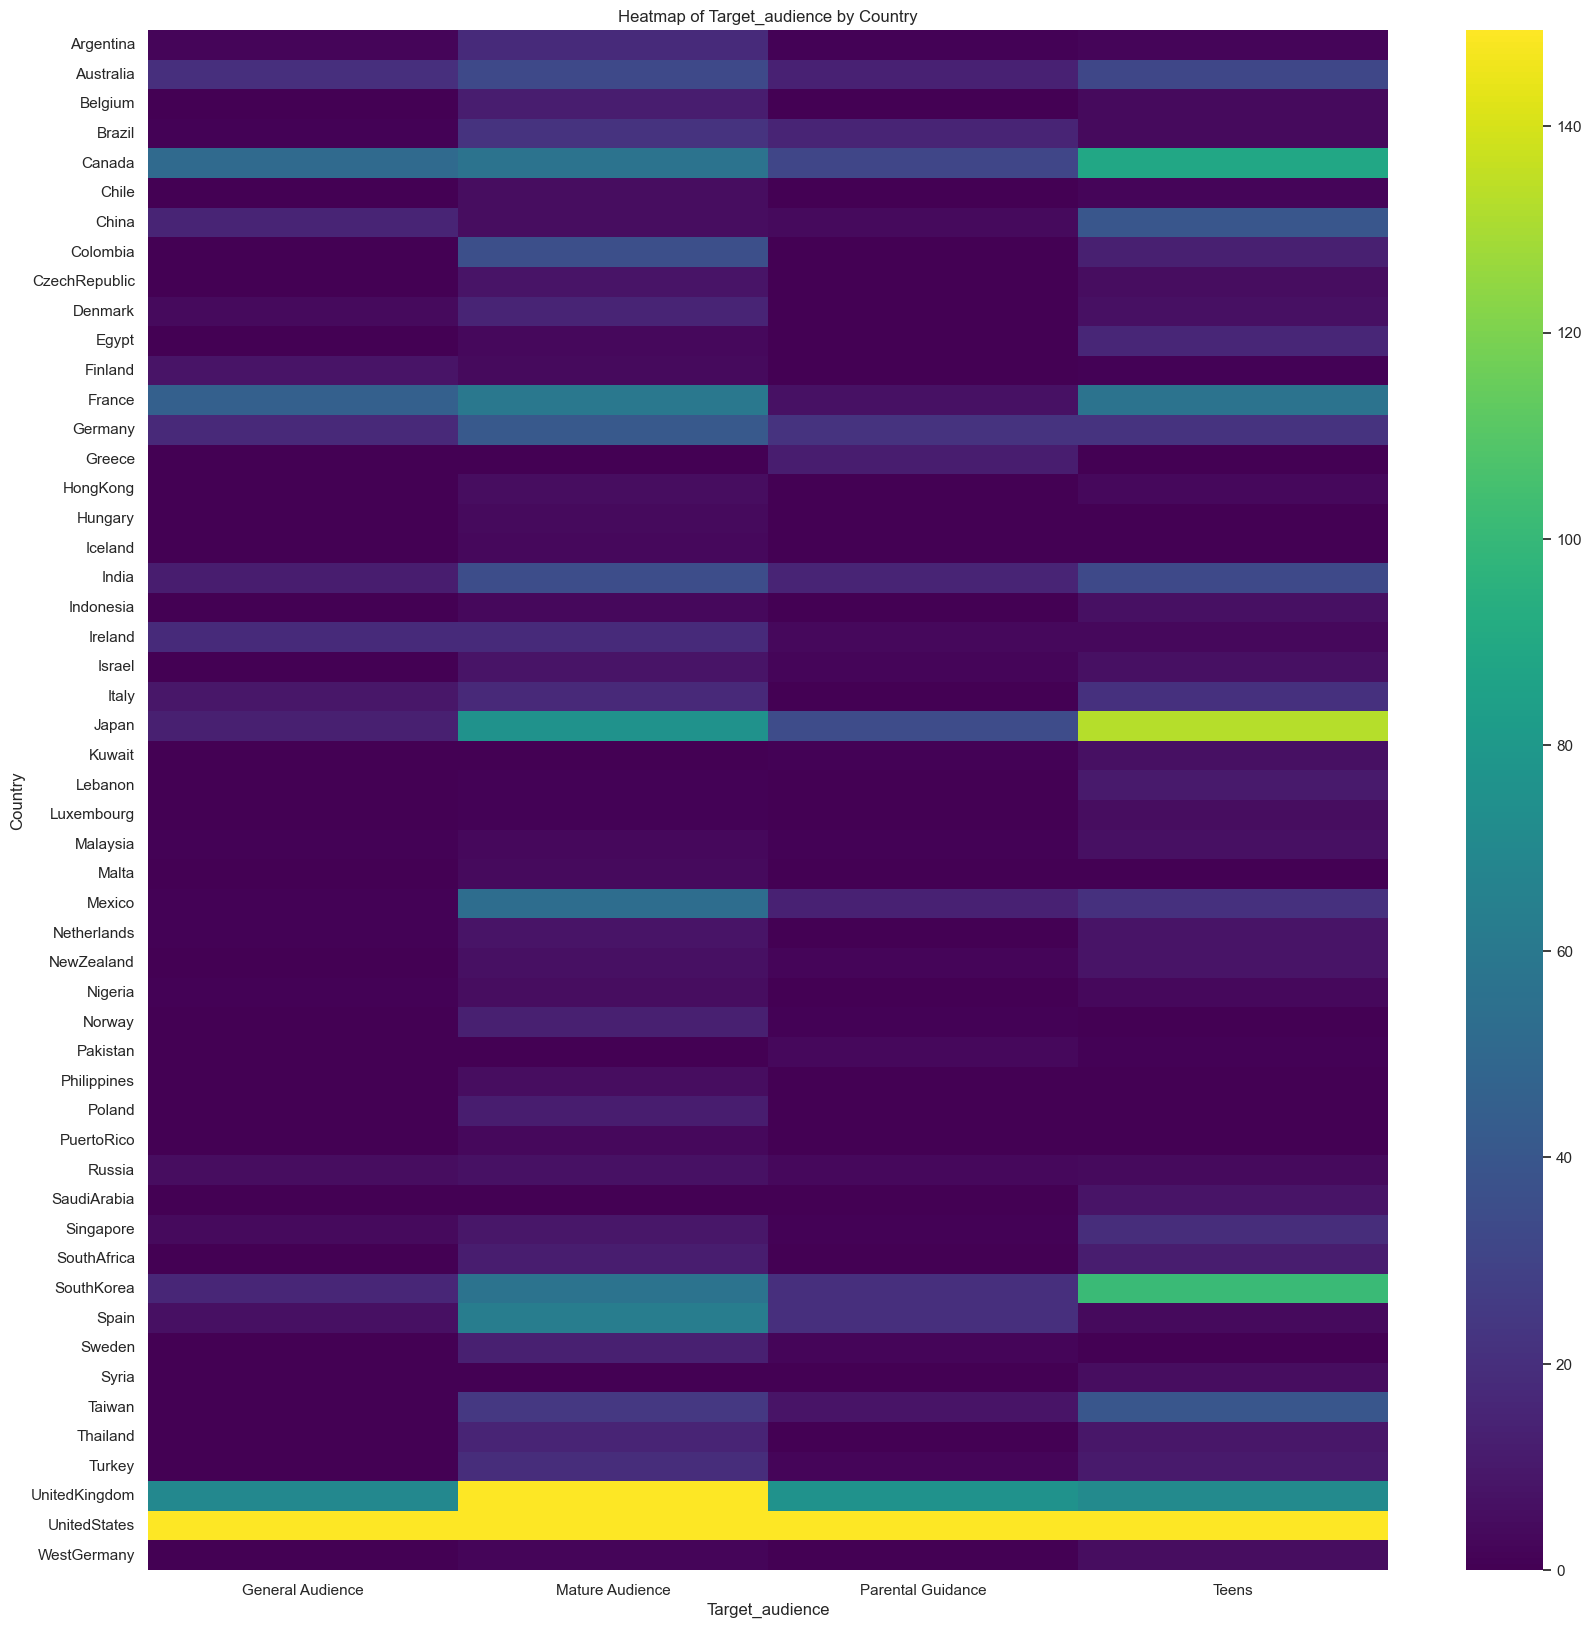

In [20]:
#Visualizing rating-Yee Jey
print(netflix_tv_show_data.Target_audience.value_counts())
plt.figure(figsize = (10,5))
sb.countplot(x="Target_audience",data = netflix_movie_data, palette = "Blues")
#Target Audience-Bryan
heatmap_data=netflix_tv_show_data.pivot_table(index='country', columns='Target_audience', aggfunc='size')
# Plot the heatmap
plt.figure(figsize=(20, 20))
sb.heatmap(heatmap_data, cmap='viridis', robust=True)
plt.xlabel('Target_audience')
plt.ylabel('Country')
plt.title('Heatmap of Target_audience by Country')
plt.show()

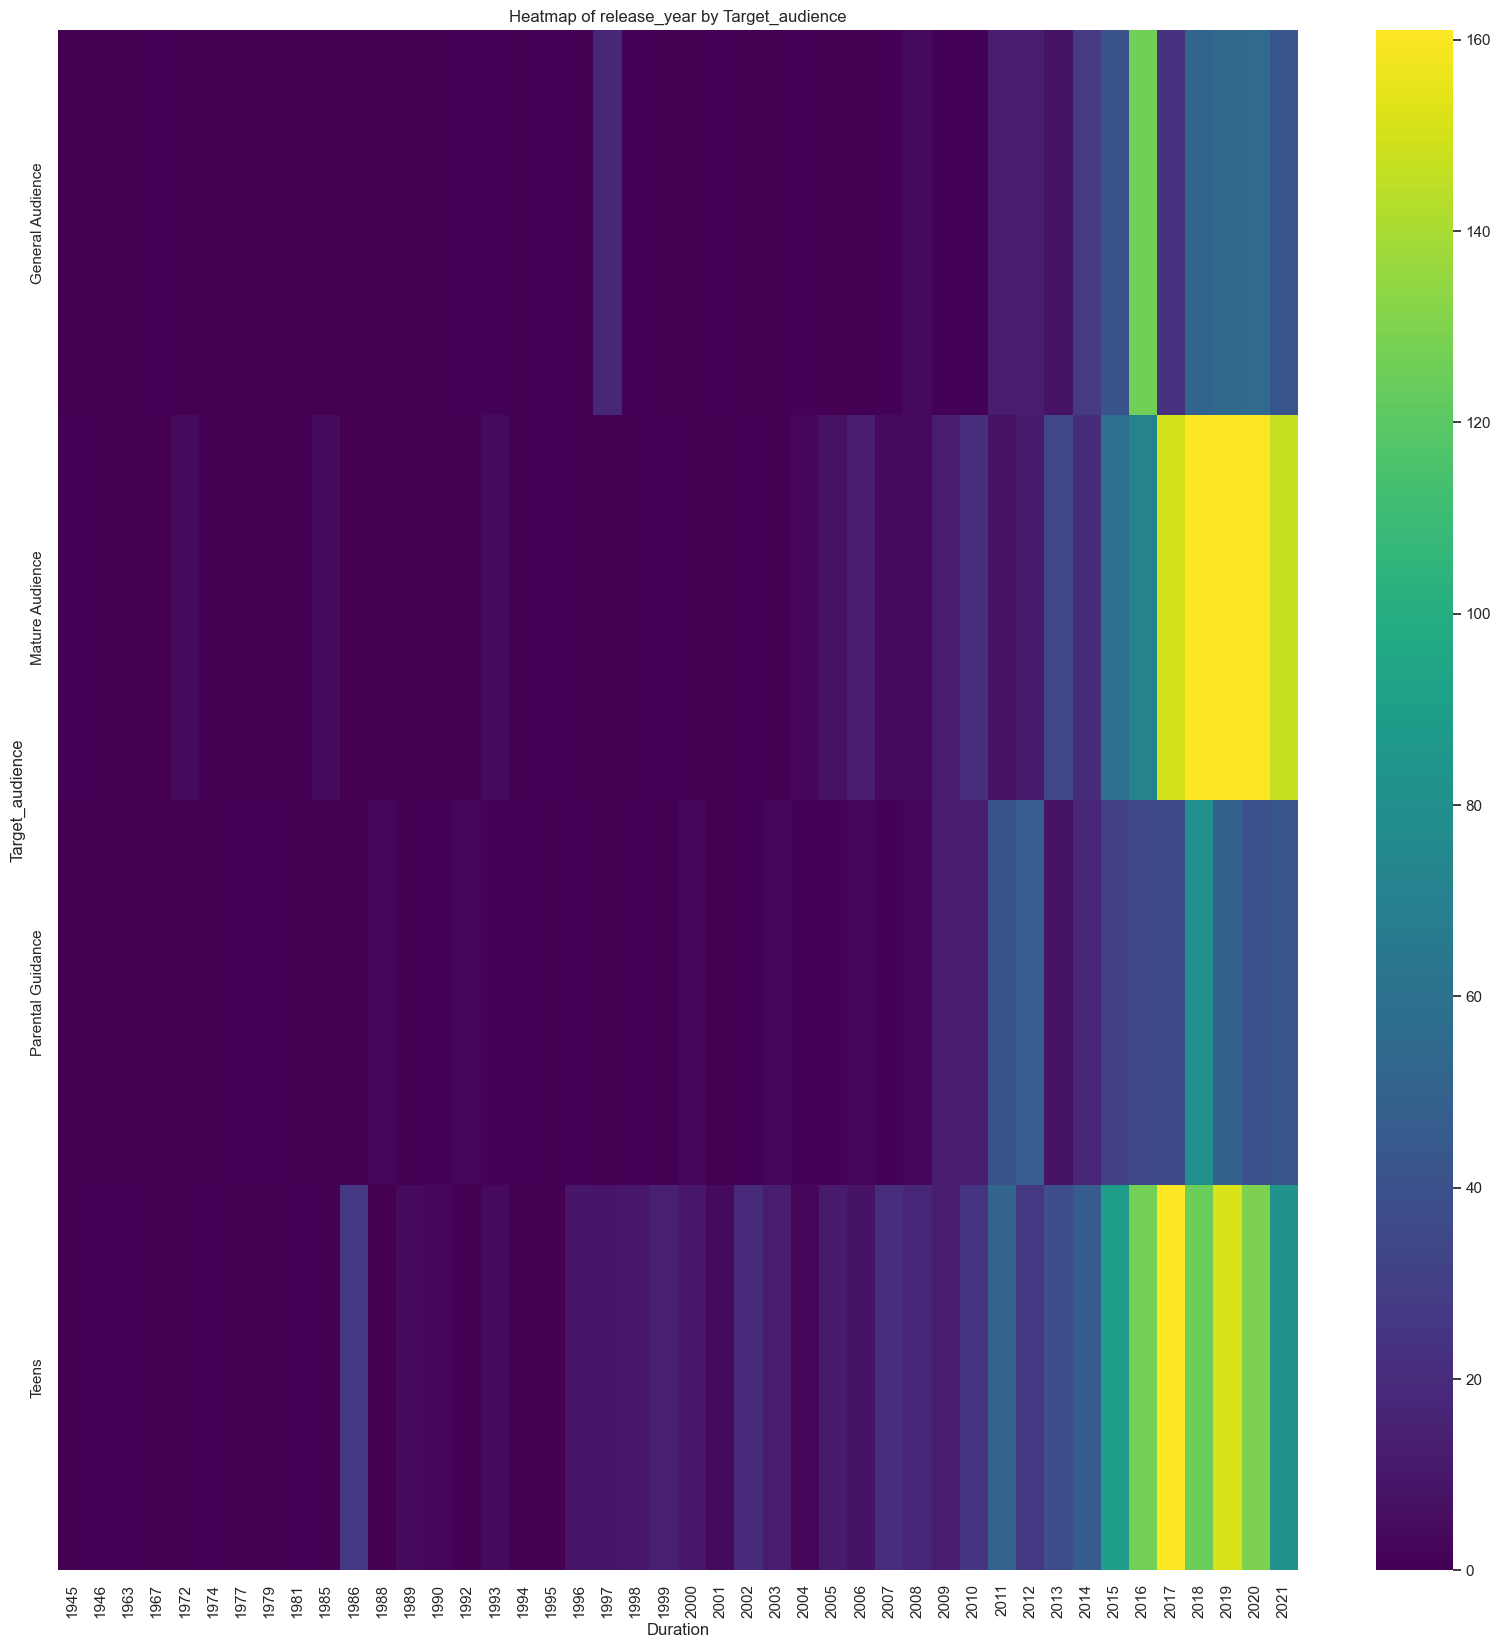

In [21]:
#Visualizing Release Year
#Duration-Bryan
heatmap_data=netflix_tv_show_data.pivot_table(index='Target_audience', columns='release_year', aggfunc='size')
# Plot the heatmap
plt.figure(figsize=(20, 20))
sb.heatmap(heatmap_data, cmap='viridis', robust=True)
plt.xlabel('Duration')
plt.ylabel('Target_audience')
plt.title('Heatmap of release_year by Target_audience')
plt.show()

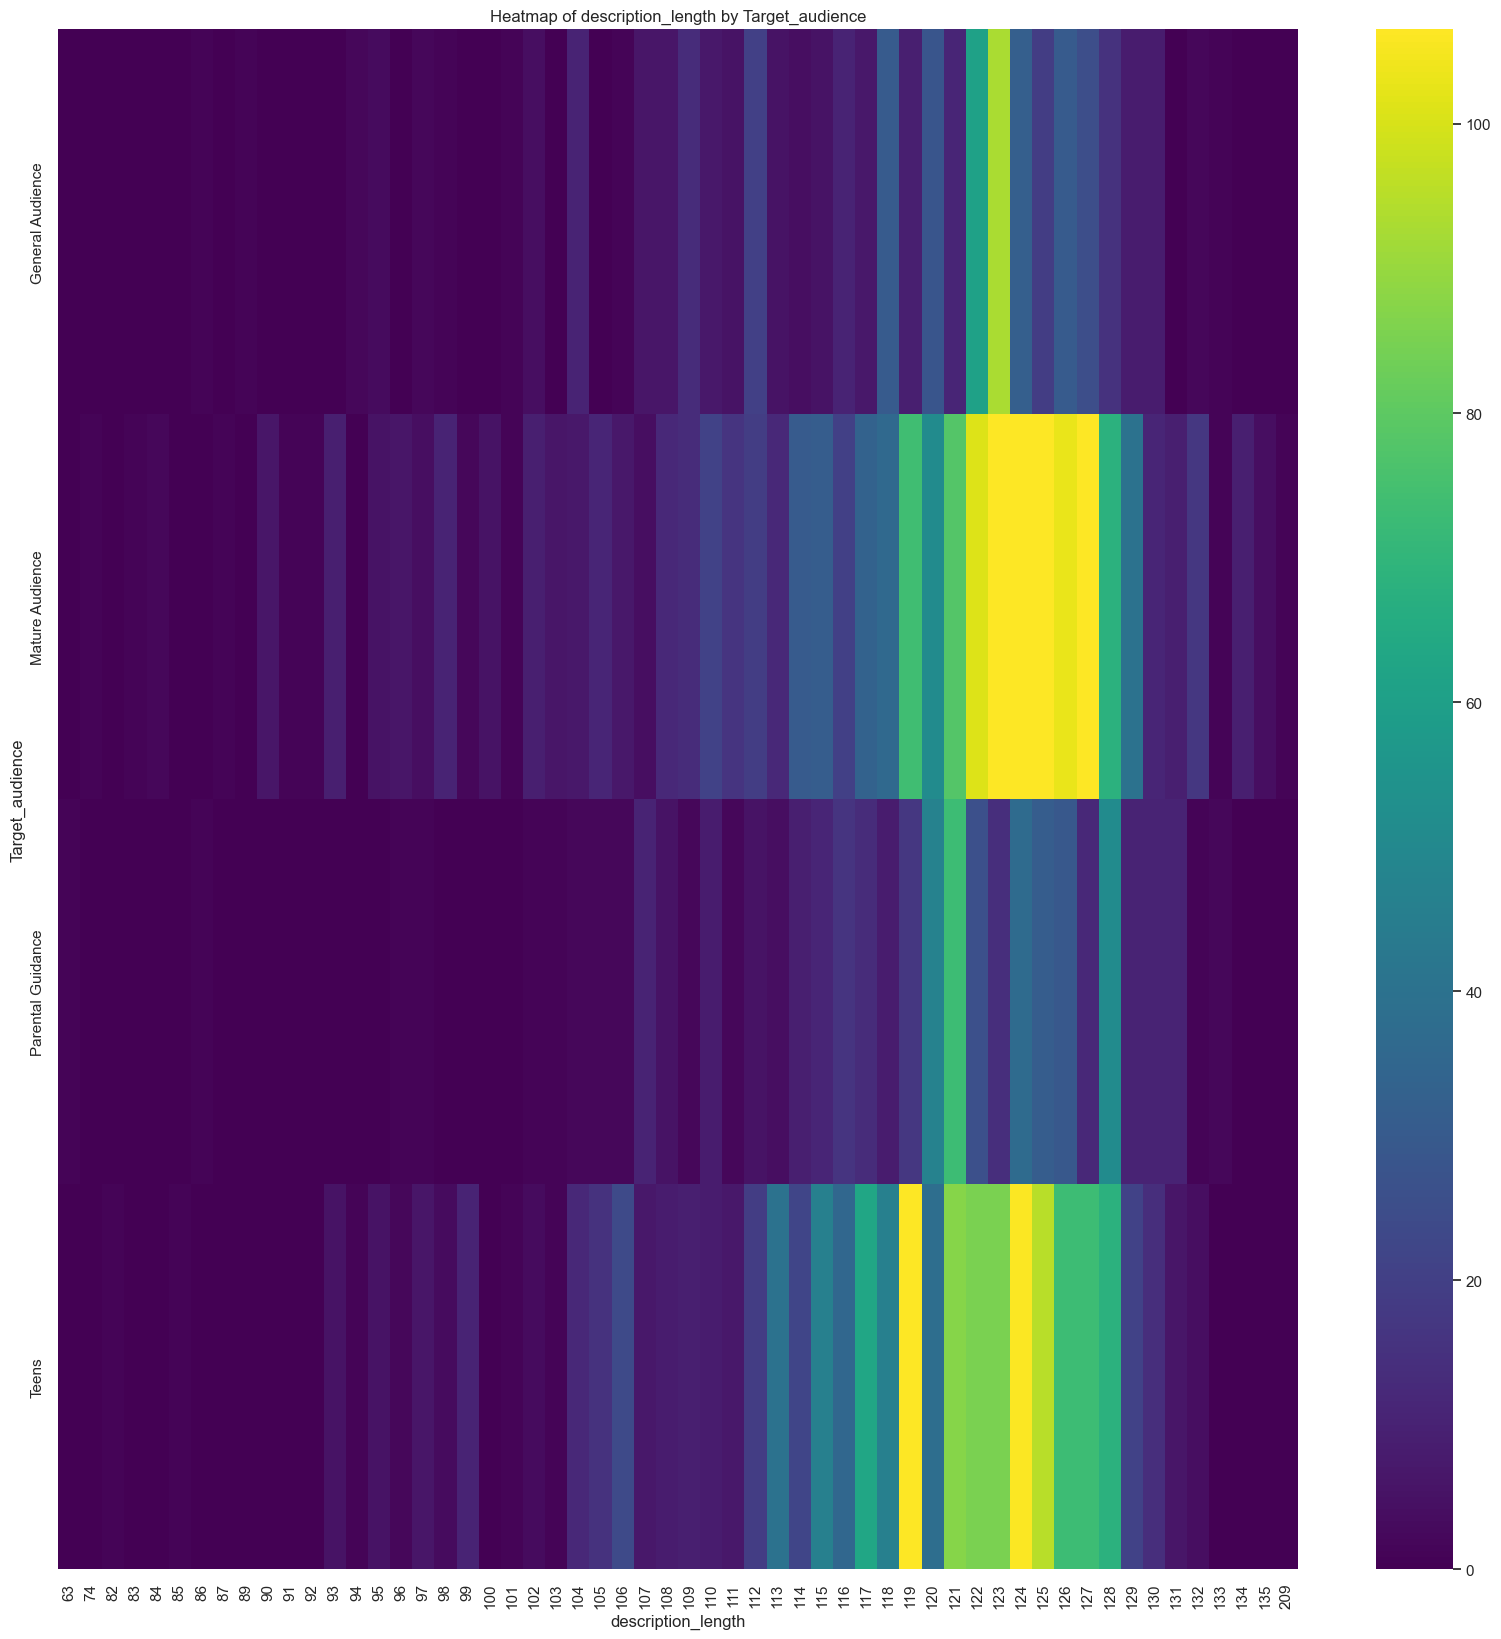

In [22]:
#Visualizing Description Length
#Duration-Bryan
heatmap_data=netflix_tv_show_data.pivot_table(index='Target_audience', columns='description_length', aggfunc='size')
# Plot the heatmap
plt.figure(figsize=(20, 20))
sb.heatmap(heatmap_data, cmap='viridis', robust=True)
plt.xlabel('description_length')
plt.ylabel('Target_audience')
plt.title('Heatmap of description_length by Target_audience')
plt.show()

# Machine Learning
Done by Bryan with some assistance from Yee Jey

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize LabelEncoder
label_encoder = LabelEncoder()

In [24]:
unique_countries = netflix_movie_data['country'].unique().tolist()
print(unique_countries)

['UnitedStates', 'India', 'Japan', 'Nigeria', 'France', 'Canada', 'HongKong', 'UnitedKingdom', 'Colombia', 'Mexico', 'SouthAfrica', 'Brazil', 'Argentina', 'Poland', 'Australia', 'NewZealand', 'SaudiArabia', 'Thailand', 'Indonesia', 'Italy', 'Egypt', 'Malaysia', 'SouthKorea', 'Vietnam', 'Lebanon', 'Romania', 'Philippines', 'Germany', 'UnitedArabEmirates', 'Netherlands', 'Spain', 'Sweden', 'Austria', 'China', 'Turkey', 'Taiwan', 'Kenya', 'Uruguay', 'Bangladesh', 'Norway', 'Singapore', 'Iceland', 'Namibia', 'Ghana', 'Chile', 'Zimbabwe', 'Kuwait', 'Hungary', 'Switzerland', 'Pakistan', 'Denmark', 'Peru', 'Israel', 'Cambodia', 'Bulgaria', 'Ireland', 'WestGermany', 'Venezuela', 'Russia', 'Belgium', 'BurkinaFaso', 'Ethiopia', 'CzechRepublic', 'Nepal', 'Greece', 'Algeria', 'Syria', 'Qatar', 'Portugal', 'CaymanIslands', 'Serbia', 'Malta', 'Luxembourg', 'Jordan', 'Senegal', 'Finland', 'Iraq', 'Iran', 'SovietUnion', 'Morocco', 'Armenia', 'Mongolia', 'Bahamas', 'Latvia', 'Croatia', 'Slovenia', 'Vat

In [25]:
# Apply LabelEncoder to convert 'categoery' to numerical labels
netflix_movie_data['Target_audience_encoded'] = label_encoder.fit_transform(netflix_movie_data['Target_audience'])
netflix_movie_data['country_encoded'] = label_encoder.fit_transform(netflix_movie_data['country'])

netflix_tv_show_data['Target_audience_encoded'] = label_encoder.fit_transform(netflix_tv_show_data['Target_audience'])
netflix_tv_show_data['country_encoded'] = label_encoder.fit_transform(netflix_tv_show_data['country'])

netflix_movie_data.dtypes

country                    category
duration                      int32
release_year                  int64
Target_audience            category
description_length            int32
Target_audience_encoded       int32
country_encoded               int32
dtype: object

In [26]:
# Count the number of unique encoded countries(double checking)
num_encoded_countries = len(netflix_movie_data['country_encoded'].unique())
print("Number of unique encoded countries:", num_encoded_countries)
num_encoded_countries = len(netflix_tv_show_data['country_encoded'].unique())
print("Number of unique encoded countries:", num_encoded_countries)

Number of unique encoded countries: 91
Number of unique encoded countries: 52


In [27]:
# Get unique countries and their encoded values
unique_countries = netflix_movie_data['country'].unique()
encoded_values = netflix_movie_data['country_encoded'].unique()

# Create a dictionary to map countries to their encoded values
country_encoding_dict = dict(zip(unique_countries, encoded_values))

# Sort the dictionary by keys (countries)
sorted_country_encoding_dict = dict(sorted(country_encoding_dict.items()))

# Print out all countries and their encoded values in order
for country, encoded_value in sorted_country_encoding_dict.items():
    print(f"{country}: {encoded_value}")

Afghanistan: 0
Algeria: 1
Argentina: 2
Armenia: 3
Australia: 4
Austria: 5
Bahamas: 6
Bangladesh: 7
Belgium: 8
Brazil: 9
Bulgaria: 10
BurkinaFaso: 11
Cambodia: 12
Canada: 13
CaymanIslands: 14
Chile: 15
China: 16
Colombia: 17
Croatia: 18
CzechRepublic: 19
Denmark: 20
Egypt: 21
Ethiopia: 22
Finland: 23
France: 24
Germany: 25
Ghana: 26
Greece: 27
HongKong: 28
Hungary: 29
Iceland: 30
India: 31
Indonesia: 32
Iran: 33
Iraq: 34
Ireland: 35
Israel: 36
Italy: 37
Japan: 38
Jordan: 39
Kenya: 40
Kuwait: 41
Latvia: 42
Lebanon: 43
Luxembourg: 44
Malaysia: 45
Malta: 46
Mexico: 47
Mongolia: 48
Morocco: 49
Namibia: 50
Nepal: 51
Netherlands: 52
NewZealand: 53
Nigeria: 54
Norway: 55
Pakistan: 56
Peru: 57
Philippines: 58
Poland: 59
Portugal: 60
Qatar: 61
Romania: 62
Russia: 63
SaudiArabia: 64
Senegal: 65
Serbia: 66
Singapore: 67
Slovenia: 68
Somalia: 69
SouthAfrica: 70
SouthKorea: 71
SovietUnion: 72
Spain: 73
Sudan: 74
Sweden: 75
Switzerland: 76
Syria: 77
Taiwan: 78
Thailand: 79
Turkey: 80
Uganda: 81
Unite

In [28]:
#Double Check to tell how it is encoded
unique_values = netflix_movie_data[['Target_audience', 'Target_audience_encoded']].drop_duplicates()

print(unique_values)

unique_values = netflix_tv_show_data[['Target_audience', 'Target_audience_encoded']].drop_duplicates()

print(unique_values)

      Target_audience  Target_audience_encoded
0               Teens                        3
9     Mature Audience                        1
12  Parental Guidance                        2
29   General Audience                        0
      Target_audience  Target_audience_encoded
0     Mature Audience                        1
2               Teens                        3
12  Parental Guidance                        2
14   General Audience                        0


# Machine learning on MOVIES

In [29]:
X = netflix_movie_data.drop(columns=['country','Target_audience','Target_audience_encoded'])
y=netflix_movie_data['Target_audience_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a Random Forest Classifier
model = RandomForestClassifier()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

Accuracy: 0.8058619602899464
              precision    recall  f1-score   support

           0       0.64      0.68      0.66        98
           1       0.86      0.82      0.84      1689
           2       0.55      0.78      0.64       152
           3       0.79      0.79      0.79      1234

    accuracy                           0.81      3173
   macro avg       0.71      0.77      0.73      3173
weighted avg       0.81      0.81      0.81      3173



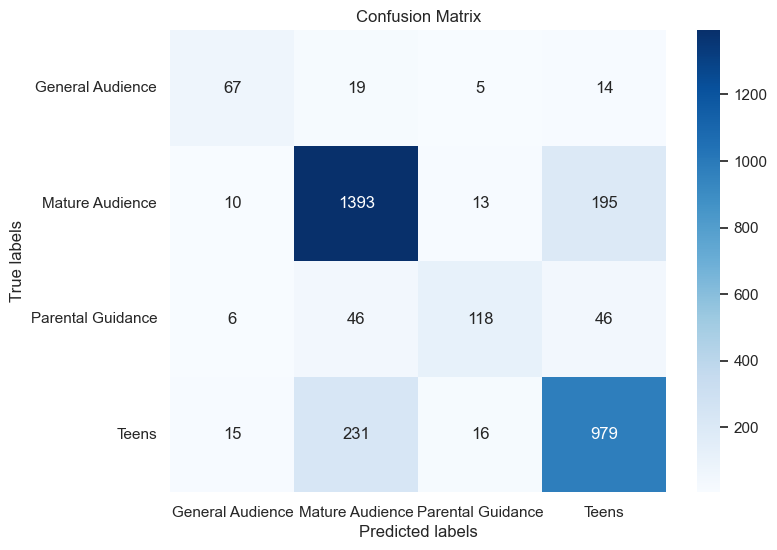

In [30]:
# Evaluating model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
#Print classificaiton report
print(classification_report(y_pred,y_test))

# Replace encoded values with their corresponding labels in y_test and y_pred
label_mapping = {0: 'General Audience', 1: 'Mature Audience', 2: 'Parental Guidance', 3: 'Teens'}

y_test_labels = y_test.map(label_mapping)
y_pred_labels = pd.Series(y_pred).map(label_mapping)

# Create confusion matrix with string labels
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sb.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

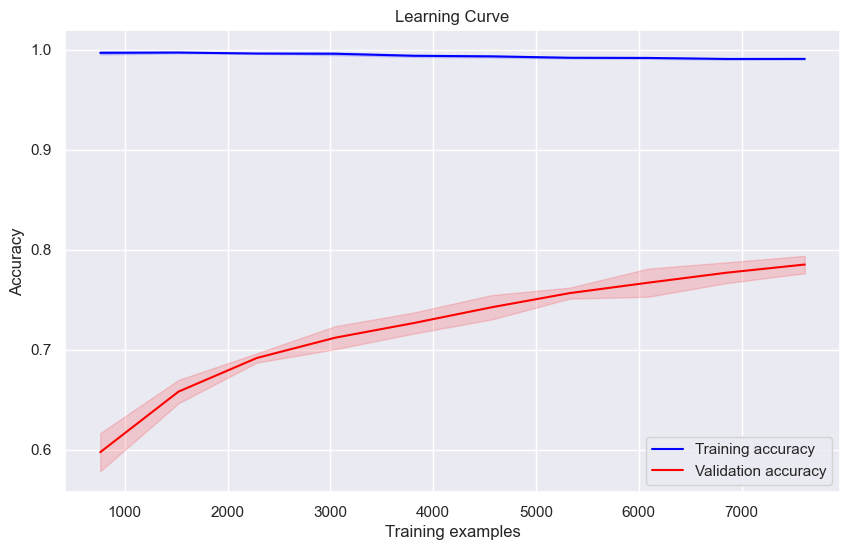

In [31]:
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, label='Validation accuracy', color='red')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='red')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()

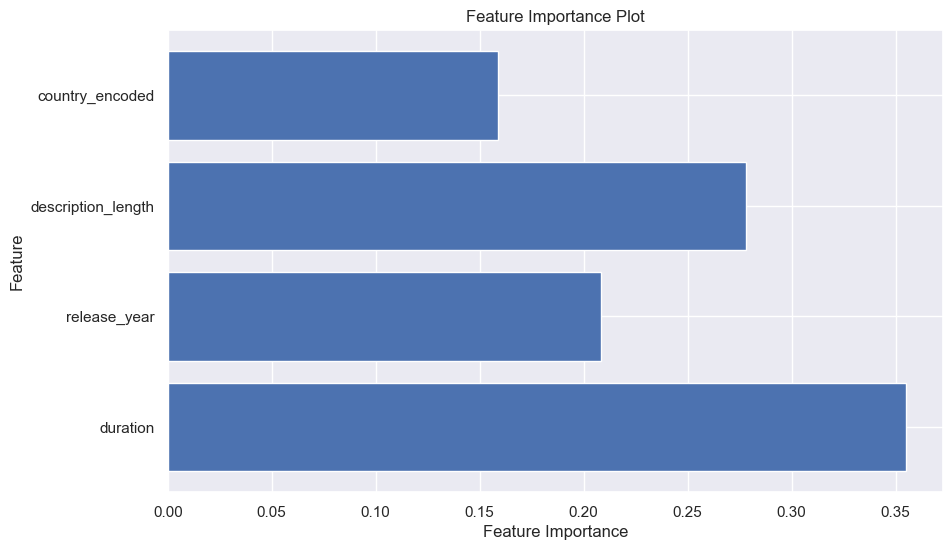

In [32]:
# Feature importance plot
importance = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

Inperpetation:From order of importance duration>description_length>release_year>country

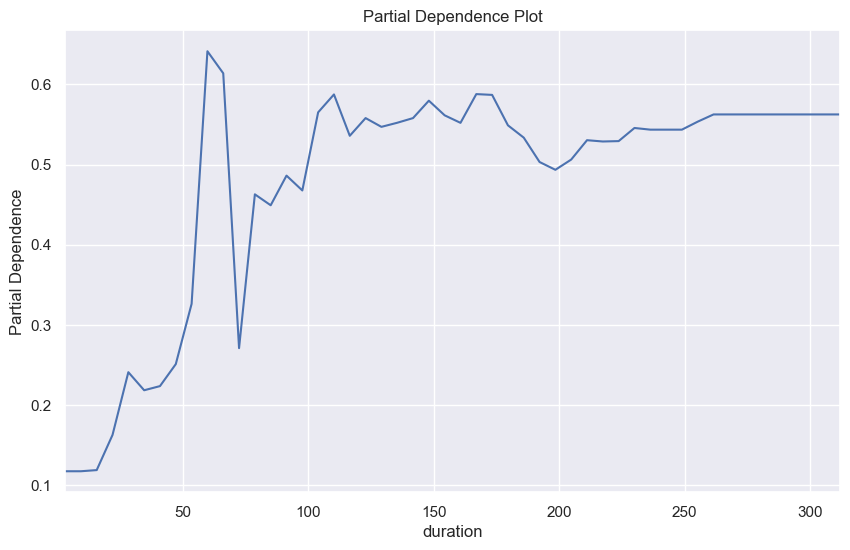

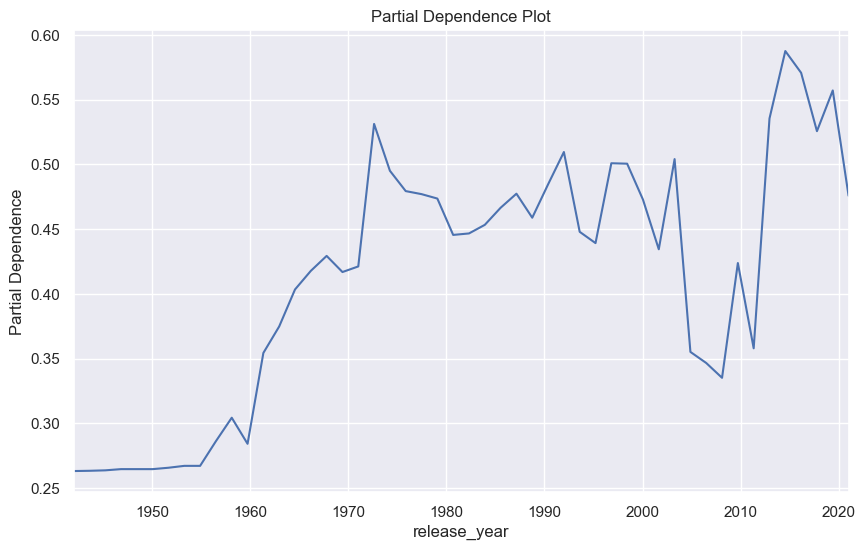

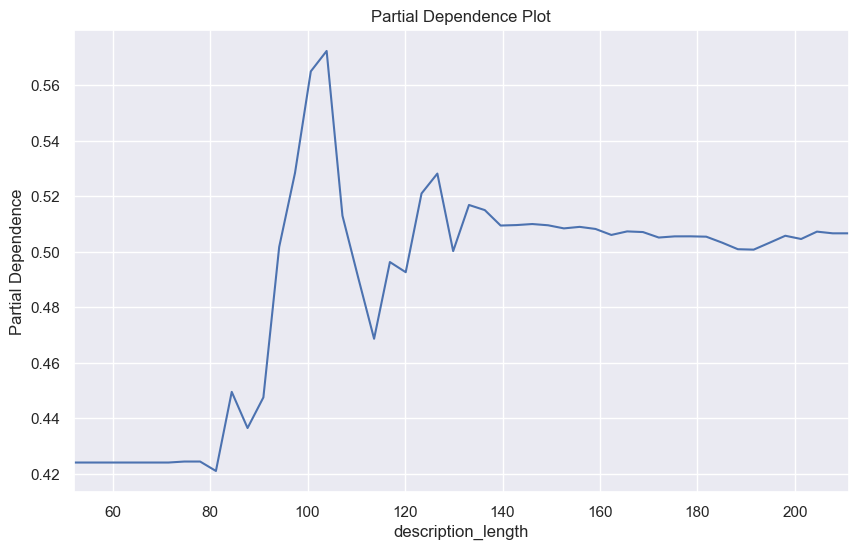

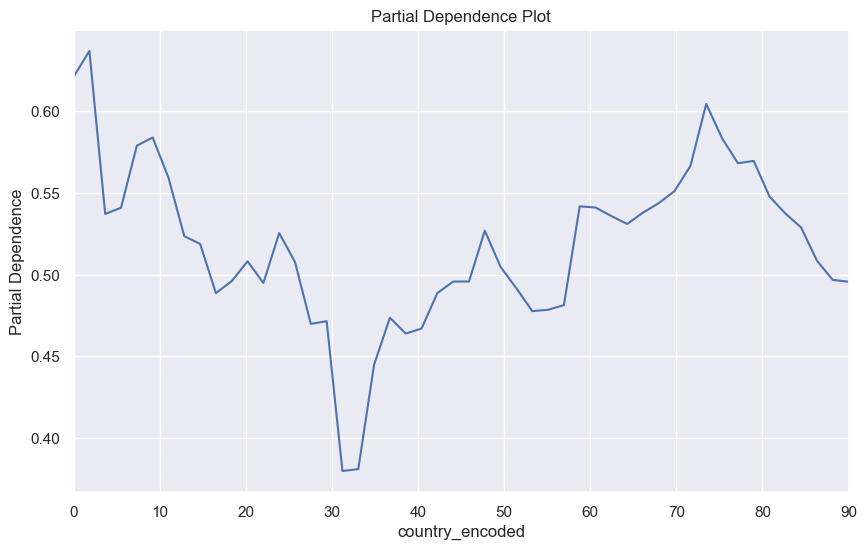

In [33]:
z=0
while z<4:
    feature_index = z 
    feature_values = np.linspace(X_train.iloc[:, feature_index].min(), X_train.iloc[:, feature_index].max(), num=50)
    pdp_values = []
    for value in feature_values:
        X_copy = X_test.copy()
        X_copy.iloc[:, feature_index] = value
        pdp_values.append(model.predict_proba(X_copy)[:, 1].mean())

    # Plot partial dependence
    plt.figure(figsize=(10, 6))
    plt.plot(feature_values, pdp_values)
    plt.xlabel(X_train.columns[feature_index])
    plt.ylabel("Partial Dependence")
    plt.title("Partial Dependence Plot")
    
    # Automatically adjust x-axis
    plt.xlim(feature_values.min(), feature_values.max())
    
    plt.show()
    z+=1

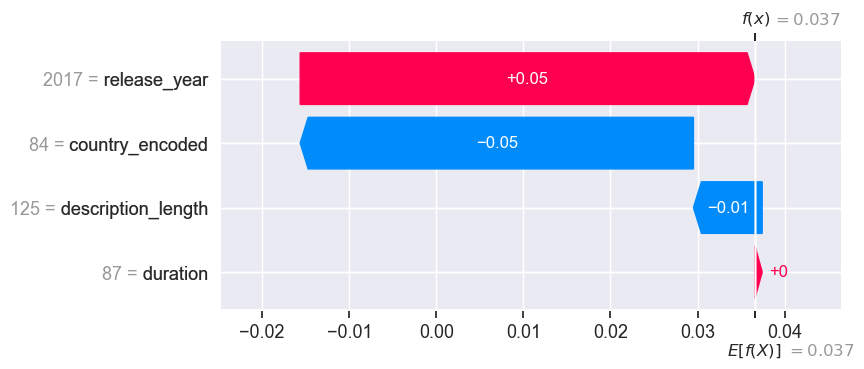

In [34]:
shap.initjs()
# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the testing set
shap_values = explainer.shap_values(X_test)

sample_idx = 0
shap.force_plot(explainer.expected_value[0], shap_values[0][sample_idx], X_test.iloc[sample_idx,:])
plt.show()

row = 3
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                              base_values=explainer.expected_value[0], data=X_test.iloc[row],  
                                         feature_names=X_test.columns.tolist()))

# Compute SHAP values for the chosen sample
shap_values = explainer.shap_values(X_test.iloc[sample_idx,:])

shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[sample_idx,:])


If you have a multi-class SHAP summary plot where the second column corresponds to label 2 and the third row corresponds to label 3, you can interpret the graph at this intersection to understand the impact of features on predicting label 3 compared to label 2.

# Machine learning on TV SHOW

In [35]:
X = netflix_tv_show_data.drop(columns=['country','Target_audience','Target_audience_encoded'])
y=netflix_tv_show_data['Target_audience_encoded']

# Split data into training and testing sets
x_train_show, x_test_show, y_trian_show, y_test_Show = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a Random Forest Classifier
model = RandomForestClassifier()

# Train the model
model.fit(x_train_show, y_trian_show)

# Make predictions
y_pred = model.predict(x_test_show)


Accuracy: 0.6416122004357299
              precision    recall  f1-score   support

           0       0.58      0.76      0.66       110
           1       0.71      0.62      0.66       393
           2       0.52      0.63      0.57        93
           3       0.64      0.63      0.63       322

    accuracy                           0.64       918
   macro avg       0.61      0.66      0.63       918
weighted avg       0.65      0.64      0.64       918



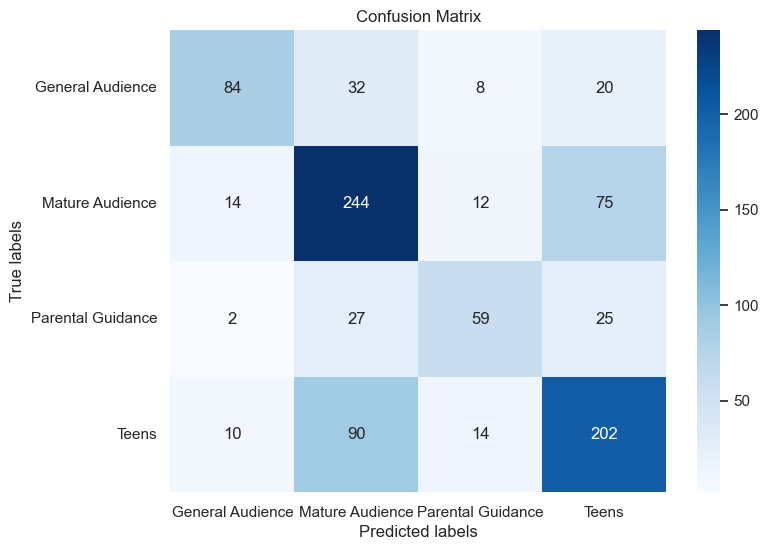

In [36]:
# Evaluating model performance
accuracy = accuracy_score(y_test_Show, y_pred)
print("Accuracy:", accuracy)

#Print classificaiton report
print(classification_report(y_pred,y_test_Show))

#Replacing encoded value with their string
label_mapping = {0: 'General Audience', 1: 'Mature Audience', 2: 'Parental Guidance', 3: 'Teens'}

y_test_Show_labels = y_test_Show.map(label_mapping)
y_pred_labels = pd.Series(y_pred).map(label_mapping)

# Create confusion matrix with string labels
conf_matrix = confusion_matrix(y_test_Show_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sb.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

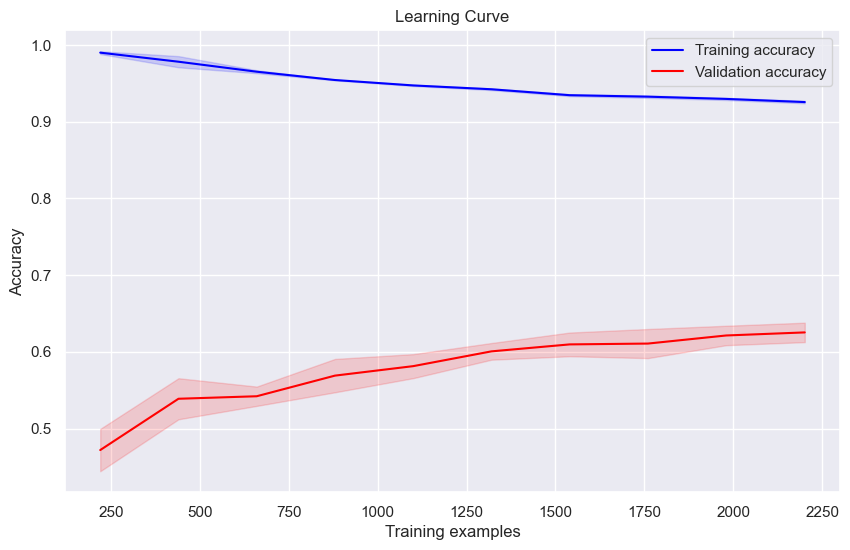

In [37]:
train_sizes, train_scores, test_scores = learning_curve(
    model, x_train_show, y_trian_show, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, label='Validation accuracy', color='red')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='red')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()

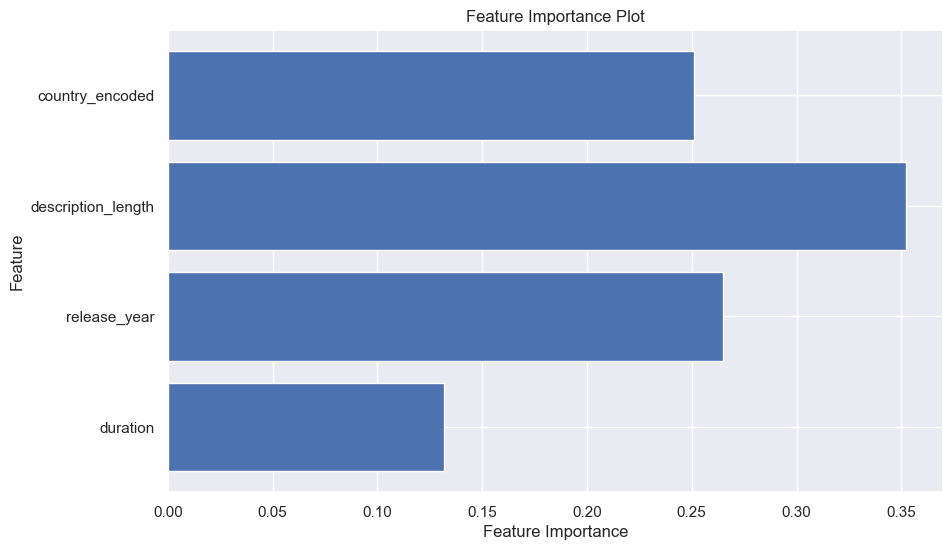

In [38]:
# Feature importance plot
importance = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

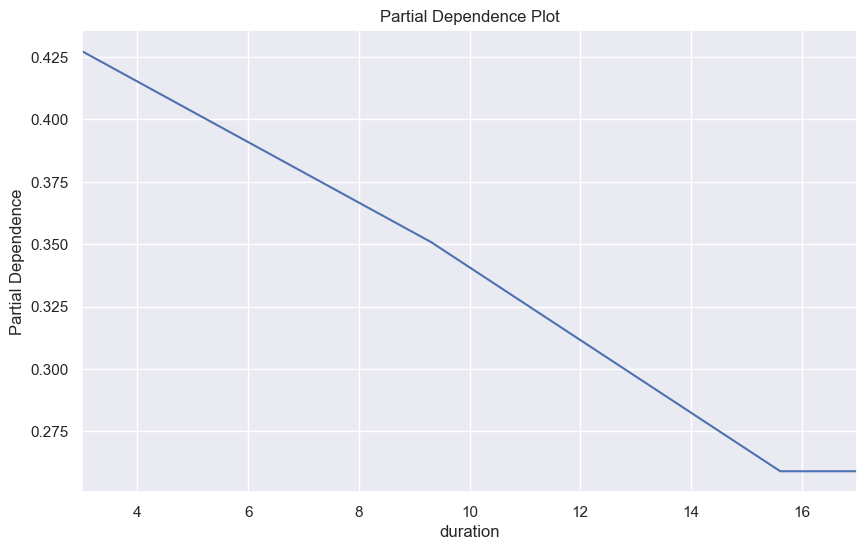

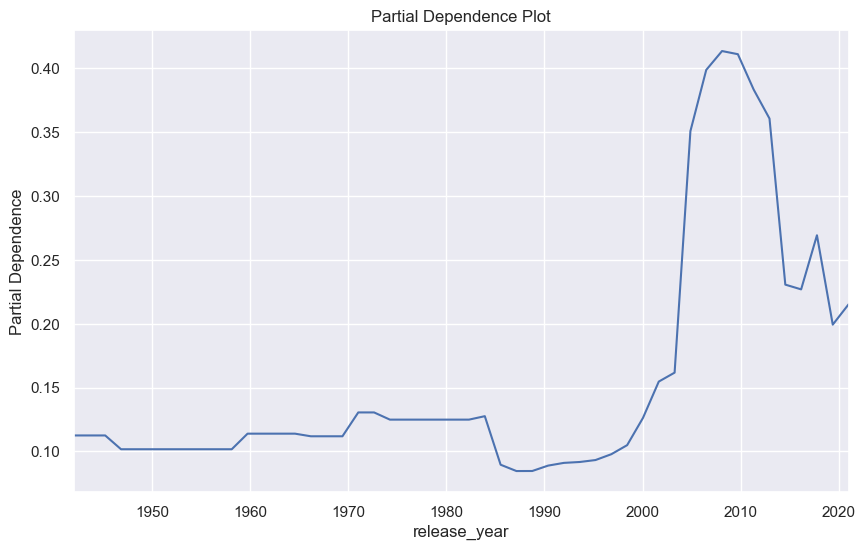

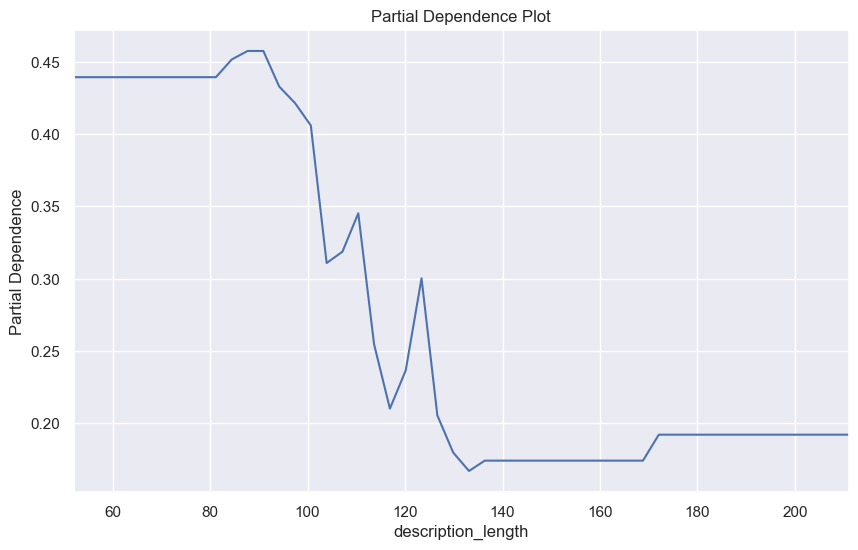

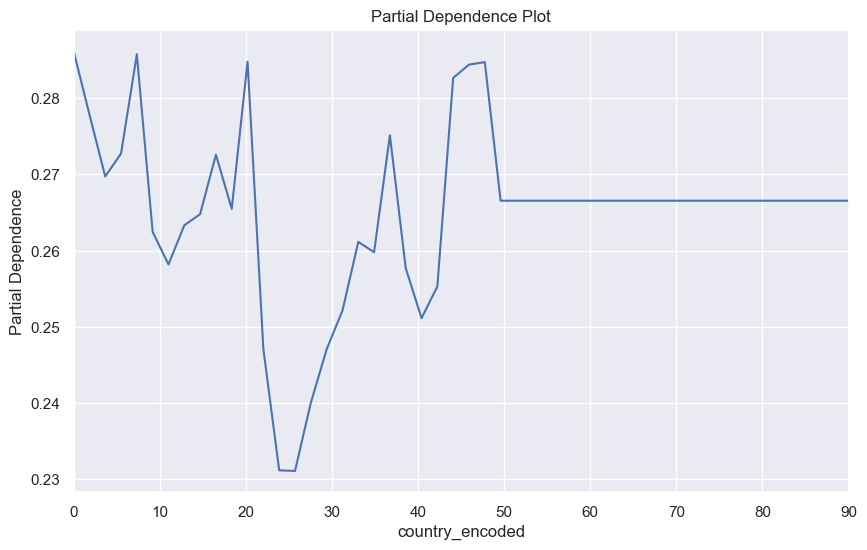

In [39]:
z = 0
while z < 4:
    feature_index = z 
    feature_values = np.linspace(X_train.iloc[:, feature_index].min(), X_train.iloc[:, feature_index].max(), num=50)
    pdp_values = []
    for value in feature_values:
        X_copy = X_test.copy()
        X_copy.iloc[:, feature_index] = value
        pdp_values.append(model.predict_proba(X_copy)[:, 1].mean())

    # Plot partial dependence
    plt.figure(figsize=(10, 6))
    plt.plot(feature_values, pdp_values)
    plt.xlabel(X_train.columns[feature_index])
    plt.ylabel("Partial Dependence")
    plt.title("Partial Dependence Plot")
    
    # Automatically adjust x-axis
    if z == 0:
        plt.xlim(feature_values.min(), 17)  # For z=0, set maximum x-axis to 17
    else:
        plt.xlim(feature_values.min(), feature_values.max())  # For other z values, use automatic adjustment
    
    plt.show()
    z += 1

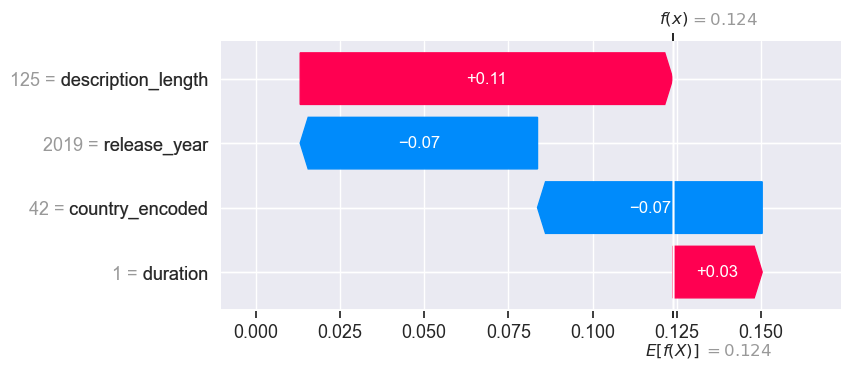

In [40]:
shap.initjs()
# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the testing set
shap_values = explainer.shap_values(x_test_show)

sample_idx = 0
shap.force_plot(explainer.expected_value[0], shap_values[0][sample_idx], x_test_show.iloc[sample_idx,:])
plt.show()

row = 3
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                              base_values=explainer.expected_value[0], data=x_test_show.iloc[row],  
                                         feature_names=x_test_show.columns.tolist()))

# Compute SHAP values for the chosen sample
shap_values = explainer.shap_values(x_test_show.iloc[sample_idx,:])

shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_show.iloc[sample_idx,:])


In [41]:
#Sample test to remove a 'negative factor' from the training data
X = netflix_tv_show_data.drop(columns=['duration','country','Target_audience','Target_audience_encoded'])
y=netflix_tv_show_data['Target_audience_encoded']

# Split data into training and testing sets
x_train_show, x_test_show, y_trian_show, y_test_Show = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a Random Forest Classifier
model = RandomForestClassifier()

# Train the model
model.fit(x_train_show, y_trian_show)

# Make predictions
y_pred = model.predict(x_test_show)

# Evaluating model performance
accuracy = accuracy_score(y_test_Show, y_pred)
print("Accuracy:", accuracy)

#Print classificaiton report
print(classification_report(y_pred,y_test_Show))


Accuracy: 0.6045751633986928
              precision    recall  f1-score   support

           0       0.49      0.67      0.57       106
           1       0.74      0.59      0.66       432
           2       0.43      0.56      0.49        88
           3       0.57      0.61      0.59       292

    accuracy                           0.60       918
   macro avg       0.56      0.61      0.58       918
weighted avg       0.63      0.60      0.61       918

